# Multidimensional Calibration Comparison

Goal: To compare two calibrations (corrections) at different points in impedance space

Method:
1. Create a set of "synthetic" standards in the DUT reference plane. These standards should have the following properties:
        + Occupy many points in impedance space
        + Be constant as a function of frequency
        + Be spaced further apart than the mean error
2. Use the reference (calibration with lowest uncertainty) to move the points to the measurement plane. This can be thought of uncorrecting the data
3. Use the comparison calibration to move the points from the measurement plane to the reference plane
4. Color code the points based on their distance from the original points 


In [1]:
from pyMez import *
from pyMez.Code.Analysis.SParameter import *

Importing pyMez, this should take roughly 30 seconds
Importing Code.DataHandlers.GeneralModels
It took 2.4 s to import Code.DataHandlers.GeneralModels
Importing Code.DataHandlers.HTMLModels
It took 0.642 s to import Code.DataHandlers.HTMLModels
Importing Code.DataHandlers.NISTModels
The module smithplot was not found,please put it on the python path
It took 3.918 s to import Code.DataHandlers.NISTModels
Importing Code.DataHandlers.TouchstoneModels
The module smithplot was not found,please put it on the python path
It took 0.07 s to import Code.DataHandlers.TouchstoneModels
Importing Code.DataHandlers.XMLModels
It took 0.783 s to import Code.DataHandlers.XMLModels
Importing Code.DataHandlers.ZipModels
It took 0.059 s to import Code.DataHandlers.ZipModels
Importing Code.InstrumentControl.Experiments
It took 11.353 s to import Code.InstrumentControl.Experiments
Importing Code.InstrumentControl.Instruments
It took 0.02 s to import Code.InstrumentControl.Instruments
Importing Code.Utils.Nam

C:\Users\anb33\AppData\Local\Continuum\anaconda2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\Users\anb33\AppData\Local\Continuum\anaconda2\lib\site-packages\odo\backends\pandas.py:102: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access NaTType as type(pandas.NaT)
  @convert.register((pd.Timestamp, pd.Timedelta), (pd.tslib.NaTType, type(None)))


In [2]:
def create_synthetic_standards_DUT_plane(frequency_list,r1=.98,r2=.2,r3=.6,**options):
    """Creates a set of points in the DUT reference plane, outputs a list of S2PV1 objects"""
    defaults={}
    standard_options={}
    for key,value in defaults.iteritems():
        standard_options[key]=value
    for key,value in options.iteritems():
        standard_options[key]=value
    output_list=[]
    s11_points=[]
    s21_points=[]
    for i in range(8):
        s11_points.append(cmath.rect(r1,cmath.pi*(i)/4))
    for i in range(4):
        s11_points.append(cmath.rect(r2,cmath.pi*(i)/2+cmath.pi/4))
    for i in range(8):
        s11_points.append(cmath.rect(r3,cmath.pi*(i)/4+cmath.pi/8))
    for i in range(8):
        s21_points.append(cmath.rect(np.sqrt(1-r1**2),cmath.pi*(i)/4))
    for i in range(4):
        s21_points.append(cmath.rect(np.sqrt(1-r2**2),cmath.pi*(i)/2+cmath.pi/4))
    for i in range(8):
        s21_points.append(cmath.rect(np.sqrt(1-r3**2),cmath.pi*(i)/4+cmath.pi/8))
    for index,point in enumerate(s11_points):
        data_list=[]
        for f in frequency_list:
            data_list.append([f,point,s21_points[index],s21_points[index],point])
        output_list.append(S2PV1(sparameter_complex=data_list,option_line='# GHz S RI R 50'))
    return output_list
            
def create_synthetic_standards_measurement_plane(r1=.98,r2=.2,r3=.6,s4p=None,**options):
    """Creates a set of points in the DUT reference plane, outputs a list of S2PV1 objects"""
    defaults={}
    standard_options={}
    for key,value in defaults.iteritems():
        standard_options[key]=value
    for key,value in options.iteritems():
        standard_options[key]=value
    frequency_list=s4p["Frequency"]
    output_list=[]
    s11_points=[]
    s21_points=[]
    for i in range(8):
        s11_points.append(cmath.rect(r1,cmath.pi*(i)/4))
    for i in range(4):
        s11_points.append(cmath.rect(r2,cmath.pi*(i)/2+cmath.pi/4))
    for i in range(8):
        s11_points.append(cmath.rect(r3,cmath.pi*(i)/4+cmath.pi/8))
    for i in range(8):
        s21_points.append(cmath.rect(np.sqrt(1-r1**2),cmath.pi*(i)/4))
    for i in range(4):
        s21_points.append(cmath.rect(np.sqrt(1-r2**2),cmath.pi*(i)/2+cmath.pi/4))
    for i in range(8):
        s21_points.append(cmath.rect(np.sqrt(1-r3**2),cmath.pi*(i)/4+cmath.pi/8))
    for index,point in enumerate(s11_points):
        data_list=[]
        for f in frequency_list:
            data_list.append([f,point,s21_points[index],s21_points[index],point])
        measurement_data_list=uncorrect_sparameters_sixteen_term(sparameters_complex=data_list,
                                           sixteen_term_correction=s4p.sparameter_complex)
        output_list.append(S2PV1(sparameter_complex=measurement_data_list,option_line='# GHz S RI R 50'))
    return output_list

def correct_all_sixteen_term(s2p_list,correction):
    """Corrects all s2ps in list and returns a new list of corrected DUTs"""
    output_list=[]
    for s2p in s2p_list:
        corrected_s2p=correct_sparameters_sixteen_term(sparameters_complex=s2p.sparameter_complex,
                                                       sixteen_term_correction=correction.sparameter_complex)
        output_list.append(S2PV1(sparameter_complex=corrected_s2p))
    return output_list

def two_port_complex_plot(s2p_list,**options):
    fig,axes=plt.subplots(nrows=2, ncols=2, figsize=(7,7),dpi=80)
    plot_names=["S11","S21","S12","S22"]
    for s2p in s2p_list:
        for index,ax in enumerate(axes.flat):
            ax.plot(s2p["re{0}".format(plot_names[index])],
                    s2p["im{0}".format(plot_names[index])],'o',fillstyle='none',markersize=10);
            ax.set_ylim([-1.2,1.2]);
            ax.set_xlim([-1.2,1.2]);
            ax.set_title(plot_names[index]);
            ax.set_xlabel("Re({0})".format(plot_names[index]))
            ax.set_ylabel("Imag({0})".format(plot_names[index]))
    plt.tight_layout()
    plt.show()
    
def two_port_complex_plot_compare(s2p_list_1,s2p_list_2,new_compare, **options):
    map(lambda x: x.change_data_format("RI"),s2p_list_1)
    map(lambda x: x.change_data_format("RI"),s2p_list_2)

    fig,axes=plt.subplots(nrows=2, ncols=2, figsize=(7,7),dpi=80)
    plot_names=["S11","S21","S12","S22"]

    for s2p in s2p_list_2:
        for index,ax in enumerate(axes.flat):
            ax.plot(s2p["re{0}".format(plot_names[index])],
                    s2p["im{0}".format(plot_names[index])],'bx');
            ax.set_ylim([-1.1,1.1]);
            ax.set_xlim([-1.1,1.1]);
            ax.set_title(plot_names[index]);
            ax.set_xlabel("Re({0})".format(plot_names[index]))
            ax.set_ylabel("Imag({0})".format(plot_names[index]))
    for s2p in s2p_list_1:
        for index,ax in enumerate(axes.flat):
            ax.plot(s2p["re{0}".format(plot_names[index])],
                    s2p["im{0}".format(plot_names[index])],'yo',fillstyle='none',markersize=10);
            ax.set_ylim([-1.1,1.1]);
            ax.set_xlim([-1.1,1.1]);
            ax.set_title(plot_names[index]);
            
            
    r11 = new_compare.get_magnitude_of_mean_difference_vector_for_radius(.98)
    r22 = new_compare.get_magnitude_of_mean_difference_vector_for_radius(.2)
    r33 = new_compare.get_magnitude_of_mean_difference_vector_for_radius(.6)
    textstr = "%s\n%s\n%s\n\n*number after tab is \nnot divided by radius" % (r11, r22, r33)
    ax.text(1.75, 2.85, textstr, transform=ax.transAxes, fontsize=16,
    verticalalignment='top')
    
    plt.rcParams.update({'font.size': 20})
    plt.subplots_adjust(left=0, bottom=0, right=3, top=1, wspace=0, hspace=0)
    plt.tight_layout()
    plt.show()
def two_port_complex_plot_compare_animate(s2p_list_1,s2p_list_2,**options):
    map(lambda x: x.change_data_format("RI"),s2p_list_1)
    map(lambda x: x.change_data_format("RI"),s2p_list_2)


    fig,axes=plt.subplots(nrows=2, ncols=2, figsize=(7,7),dpi=80)
    plot_names=["S11","S21","S12","S22"]
    images=[]
    frequency_list=s2p_list_2[0]["Frequency"]
    for f_index,f in enumerate(frequency_list):
    
        for s2p in s2p_list_2:
            for index,ax in enumerate(axes.flat):
                ax.plot(s2p["re{0}".format(plot_names[index])][f_index],
                        s2p["im{0}".format(plot_names[index])][f_index],'bx');
                ax.set_xlim([-1.1,1.1]);
                ax.set_title(plot_names[index]); 
        for s2p in s2p_list_1:
            for index,ax in enumerate(axes.flat):
                ax.plot(s2p["re{0}".format(plot_names[index])][f_index],
                        s2p["im{0}".format(plot_names[index])][f_index],'yo',fillstyle='none',markersize=10);
                ax.set_ylim([-1.1,1.1]);
                ax.set_xlim([-1.1,1.1]);
                ax.set_title(plot_names[index]);
        fig.suptitle("f = {0}".format(f))
        
        plt.tight_layout()
        plt.savefig("C:\Share\Calibration_Comparison\TRLvsSeriesR4\Calibration_Compare_f_{0}.png".format(f))
        
def compare_calibrations_script(c1_path,c2_path, new_compare):
    """"""
    c1=SNP(c1_path,number_ports=4)
    c2=SNP(c2_path,number_ports=4)
    r1=.98
    r2=.2
    r3=.6
    s2p_list=create_synthetic_standards_DUT_plane(c1["Frequency"],r1,r2,r3)
    measurement_plane_s2ps=create_synthetic_standards_measurement_plane(r1,r2,r3,c1)
    comparison_s2ps_dut_plane=correct_all_sixteen_term(measurement_plane_s2ps,c2)
    two_port_complex_plot_compare(s2p_list,comparison_s2ps_dut_plane, new_compare)

In [3]:
class CalibrationComparison(object):
    """The CalibrationComparison class is meant to compare two calibrations by taking synthetic DUTs, complex constants as
    a function of frequency. Then uncalibrating using a reference calibration and recalibrating using a calibration 
    to compare.   """
    
    def __init__(self,c1_path,c2_path):
        """"""
        self.c1=SNP(c1_path,number_ports=4)
        self.c2=SNP(c2_path,number_ports=4)
        r1=.98
        r2=.2
        r3=.6
        self.s2p_list=create_synthetic_standards_DUT_plane(self.c1["Frequency"],r1,r2,r3)
        self.measurement_plane_s2ps=create_synthetic_standards_measurement_plane(r1,r2,r3,self.c1)
        self.comparison_s2ps_dut_plane=correct_all_sixteen_term(self.measurement_plane_s2ps,self.c2)
        
        self.synthetic_DUT_average_array=[]
        for s2p in self.s2p_list[:]:
            self.synthetic_DUT_average_array.append(np.mean(np.array(s2p.sparameter_complex[:]), axis = 0))

        self.comparison_s2ps_dut_plane_average_array=[]
        for s2p in self.comparison_s2ps_dut_plane[:]:
            self.comparison_s2ps_dut_plane_average_array.append(np.mean(np.array(s2p.sparameter_complex[:]), axis = 0))
        
        self.average_difference_arr_s11 = []
        self.average_difference_arr_s21 = []
        self.average_difference_arr_s12 = []
        self.average_difference_arr_s22 = []
        for r in range (0, len(self.synthetic_DUT_average_array)):
            for i in range(1,5):
                if (i == 1):
                    self.average_difference_arr_s11.append(self.comparison_s2ps_dut_plane_average_array[r][1] - self.synthetic_DUT_average_array[r][1])
                if (i == 2):
                    self.average_difference_arr_s21.append(self.comparison_s2ps_dut_plane_average_array[r][2] - self.synthetic_DUT_average_array[r][2])
                if (i == 3):
                    self.average_difference_arr_s12.append(self.comparison_s2ps_dut_plane_average_array[r][3] - self.synthetic_DUT_average_array[r][3])
                if (i == 4):
                    self.average_difference_arr_s22.append(self.comparison_s2ps_dut_plane_average_array[r][4] - self.synthetic_DUT_average_array[r][4])
    
    def show(self):
        two_port_complex_plot_compare(self.s2p_list,self.comparison_s2ps_dut_plane, self)
        
    def vector_field_complex_plot_compare(self, s2p_list_1, s2p_list_2, **options):
        #s11 Plot
        s11_real = []
        s11_imag = []
        for i in range (0, len(self.s2p_list)):
            s11_real.append(self.s2p_list[i].data[0][1])
            s11_imag.append(self.s2p_list[i].data[0][2])
        avg_s11_real = []
        avg_s11_imag = []
        for i in range (0, len(self.average_difference_arr_s11)):
            avg_s11_real.append(self.average_difference_arr_s11[i].real)
            avg_s11_imag.append(self.average_difference_arr_s11[i].imag)

            #s21 Plot
        s21_real = []
        s21_imag = []
        for i in range (0, len(self.s2p_list)):
            s21_real.append(self.s2p_list[i].data[0][3])
            s21_imag.append(self.s2p_list[i].data[0][4])
        avg_s21_real = []
        avg_s21_imag = []
        for i in range (0, len(self.average_difference_arr_s21)):
            avg_s21_real.append(self.average_difference_arr_s21[i].real)
            avg_s21_imag.append(self.average_difference_arr_s21[i].imag)

        #s12 Plot
        s12_real = []
        s12_imag = []
        for i in range (0, len(self.s2p_list)):
            s12_real.append(self.s2p_list[i].data[0][5])
            s12_imag.append(self.s2p_list[i].data[0][6])
        avg_s12_real = []
        avg_s12_imag = []
        for i in range (0, len(self.average_difference_arr_s12)):
            avg_s12_real.append(self.average_difference_arr_s12[i].real)
            avg_s12_imag.append(self.average_difference_arr_s12[i].imag)

            #s22 Plot
        s22_real = []
        s22_imag = [] 
        for i in range (0, len(self.s2p_list)):
            s22_real.append(self.s2p_list[i].data[0][7])
            s22_imag.append(self.s2p_list[i].data[0][8])
        avg_s22_real = []
        avg_s22_imag = []
        for i in range (0, len(self.average_difference_arr_s22)):
            avg_s22_real.append(self.average_difference_arr_s22[i].real)
            avg_s22_imag.append(self.average_difference_arr_s22[i].imag)

        #x and y of quiver plot are real-imaginary numbers of the synthetic DUT
        #u and v of quiver plot are the real-imaginary mean differences of the synthetic + corrected locations
        f, axarr = plt.subplots(2, 2)
        plot_names=["S11","S21","S12","S22"]
        axarr[0, 0].quiver(s11_real, s11_imag, avg_s11_real, avg_s11_imag)
        axarr[0, 0].set_xlabel('Re(S11)')
        axarr[0, 0].set_ylabel('Imag(S11)')
        axarr[0, 1].quiver(s21_real, s21_imag, avg_s21_real, avg_s21_imag)
        axarr[0, 1].set_xlabel('Re(S21)')
        axarr[0, 1].set_ylabel('Imag(S21)')
        axarr[1, 0].quiver(s12_real, s12_imag, avg_s12_real, avg_s12_imag)
        axarr[1, 0].set_xlabel('Re(S12)')
        axarr[1, 0].set_ylabel('Imag(S12)')
        axarr[1, 1].quiver(s22_real, s22_imag, avg_s22_real, avg_s22_imag)
        axarr[1, 1].set_xlabel('Re(S22)')
        axarr[1, 1].set_ylabel('Imag(S22)')
        plt.rcParams.update({'font.size': 15})
        plt.tight_layout()
        
    #gets the sum of the averaged differences for a specific s parameter (added magnitude of vectors for all radii)
    def get_magnitude_of_mean_difference_vector(self, arr_s):
        sum_of_s = 0
        for i in range(0, len(arr_s)): 
            sum_of_s += abs(arr_s[i])
        return sum_of_s/len(arr_s)
    
    #gets the sum of the averaged differences for a specific radius from the center. Returns sums for all s-parameters in an array.
    def get_magnitude_of_mean_difference_vector_for_radius(self, radius):
        s11_r, s21_r, s12_r, s22_r = [],[],[],[]
        s11, s21, s12, s22 = 0,0,0,0
        magnitude_arr = []
        magnitude_arr2 = []
        if radius == 0.98:
            i = 0
            j = 8
        elif radius == .2:
            i = 8
            j = 12
        elif radius == .6:
            i = 12
            j = 20
        else:
            return "error"
        for x in range (i, j):
            s11_r.append(self.average_difference_arr_s11[x])
            s21_r.append(self.average_difference_arr_s21[x])
            s12_r.append(self.average_difference_arr_s12[x])
            s22_r.append(self.average_difference_arr_s22[x])
        for z in range (0, len(s11_r)):
            s11 += abs(s11_r[z])
            s21 += abs(s21_r[z])
            s12 += abs(s12_r[z])
            s22 += abs(s22_r[z])
        magnitude_arr.append(s11/radius)
        magnitude_arr.append(s21/np.sqrt(1-radius**2))
        magnitude_arr.append(s12/np.sqrt(1-radius**2))
        magnitude_arr.append(s22/radius)
        
        magnitude_arr2.append(s11)
        magnitude_arr2.append(s21)
        magnitude_arr2.append(s12)
        magnitude_arr2.append(s22)
        
        all_sp_mean = (s11/radius + s21/np.sqrt(1-radius**2) + s12/np.sqrt(1-radius**2) + s22/radius) / 4
        
        return str(radius) + "\n" + "sp/radius" + "\t"  + "sp" + "\n" + "S11: " + str("{0:3.3}".format(magnitude_arr[0])) + "\t" + str("{0:3.3}".format(magnitude_arr2[0])) + "\nS21: " + str("{0:3.3}".format(magnitude_arr[1])) + "\t" + str("{0:3.3}".format(magnitude_arr2[1])) + "\nS12: " + str("{0:3.3}".format(magnitude_arr[2])) + "\t" + str("{0:3.3}".format(magnitude_arr2[2])) + "\nS22: " + str("{0:3.3}".format(magnitude_arr[3])) + "\t" + str("{0:3.3}".format(magnitude_arr2[3])) + "\nMean of All S-Parameters w/ Division: " + str("{0:3.3}".format(all_sp_mean))

In [4]:
comparison_correction= r"C:\Users\anb33\Desktop\Compare Stuff\Solution_1.s4p"
comparison_correction_1=r"C:\Users\anb33\Desktop\Compare Stuff\Solution_3.s4p"
comparison_correction_2=r"C:\Users\anb33\Desktop\Compare Stuff\Solution_6.s4p"
comparison_correction_3=r"C:\Users\anb33\Desktop\Compare Stuff\Solution_8.s4p"
reference_correction=r"C:\Users\anb33\Desktop\Compare Stuff\Solution_1.s4p"
reference_correction_new_standard = r"Q:\public\Aric\Summer 2018\Arpita\Calibrations Using Different Standards\TRL_1.s4p"
comparison_correction_standard1 = r"Q:\public\Aric\Summer 2018\Arpita\Calibrations Using Different Standards\SOLT_1.s4p"
comparison_correction_standard2 = r"Q:\public\Aric\Summer 2018\Arpita\Calibrations Using Different Standards\LRL_1.s4p"
comparison_correction_standard3 = r"Q:\public\Aric\Summer 2018\Arpita\Calibrations Using Different Standards\MTRL_1.s4p"
comparison_correction_standard4 = r"Q:\public\Aric\Summer 2018\Arpita\Calibrations Using Different Standards\MTRL_2.s4p"
comparison_correction_standard5 = r"Q:\public\Aric\Summer 2018\Arpita\Calibrations Using Different Standards\MTRL_3_Statistical.s4p"
comparison_correction_standard6 = r"Q:\public\Aric\Summer 2018\Arpita\Calibrations Using Different Standards\TRL_2.s4p"
comparison_correction_standard7 = r"Q:\public\Aric\Summer 2018\Arpita\Calibrations Using Different Standards\TRL_3.s4p"

In [22]:
cal1_2017 = ["Solution20170804.s4p", "Solution20170809.s4p", "Solution20170810.s4p", "Solution20170811.s4p",
           "Solution20170814.s4p", "Solution20170824.s4p", "Solution20171006.s4p", "Solution20171011.s4p",
           "Solution20171012.s4p", "Solution20171013.s4p", "Solution20171016.s4p", "Solution20171017.s4p"]

<Figure size 432x288 with 0 Axes>

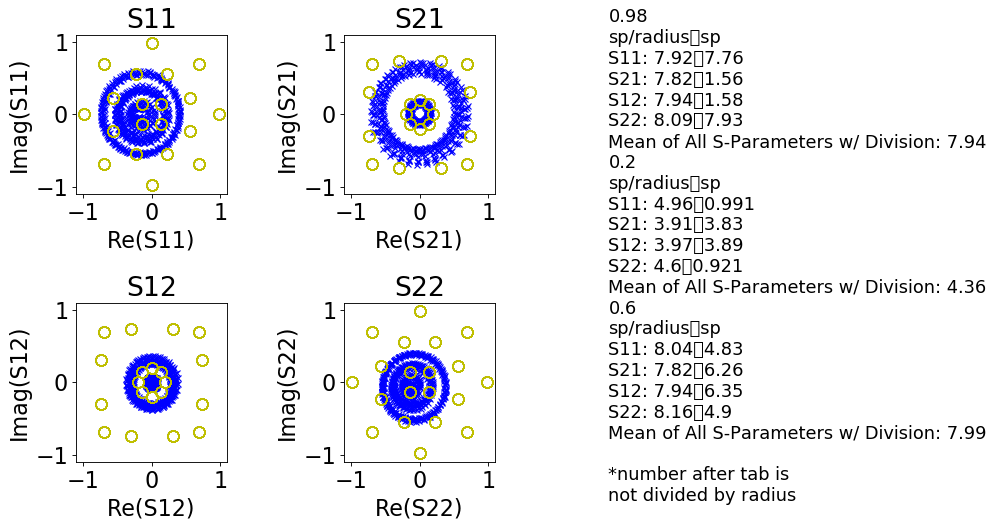

<Figure size 432x288 with 0 Axes>

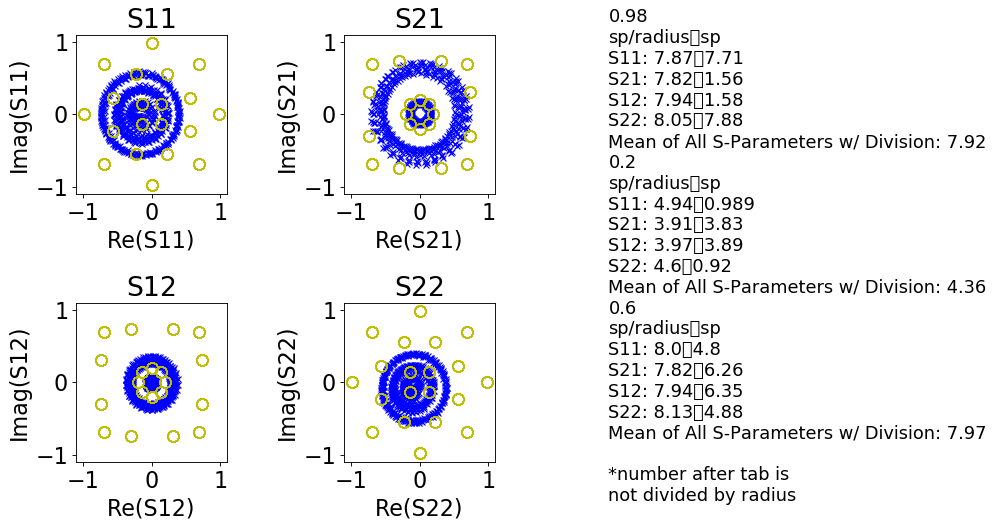

<Figure size 432x288 with 0 Axes>

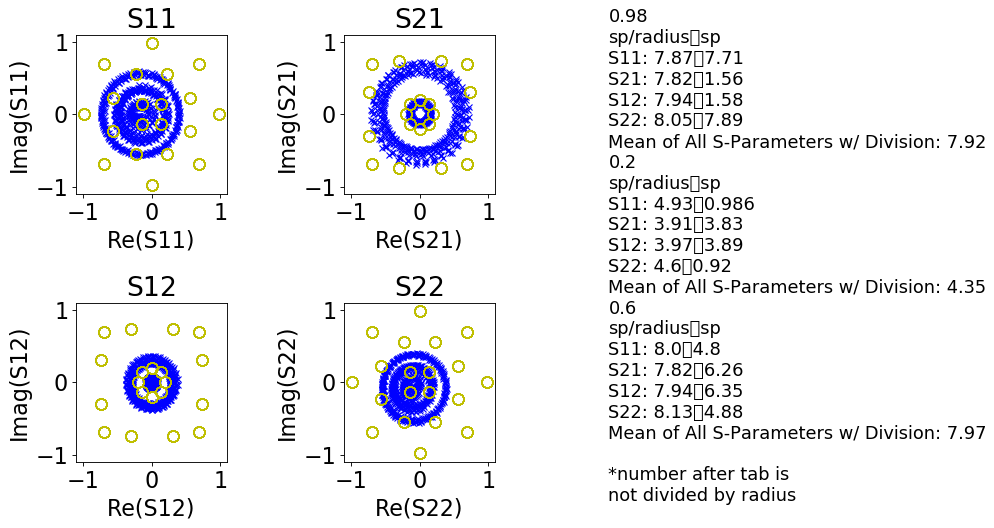

<Figure size 432x288 with 0 Axes>

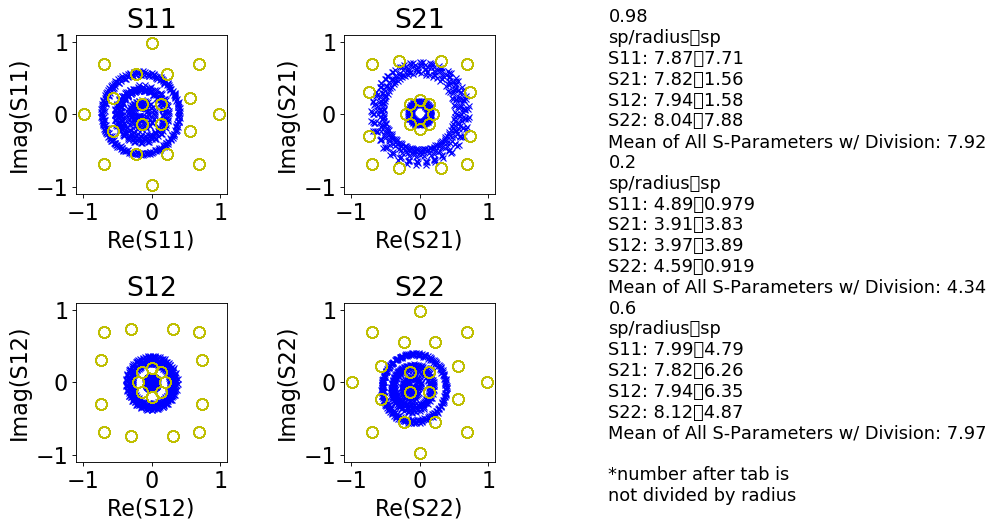

<Figure size 432x288 with 0 Axes>

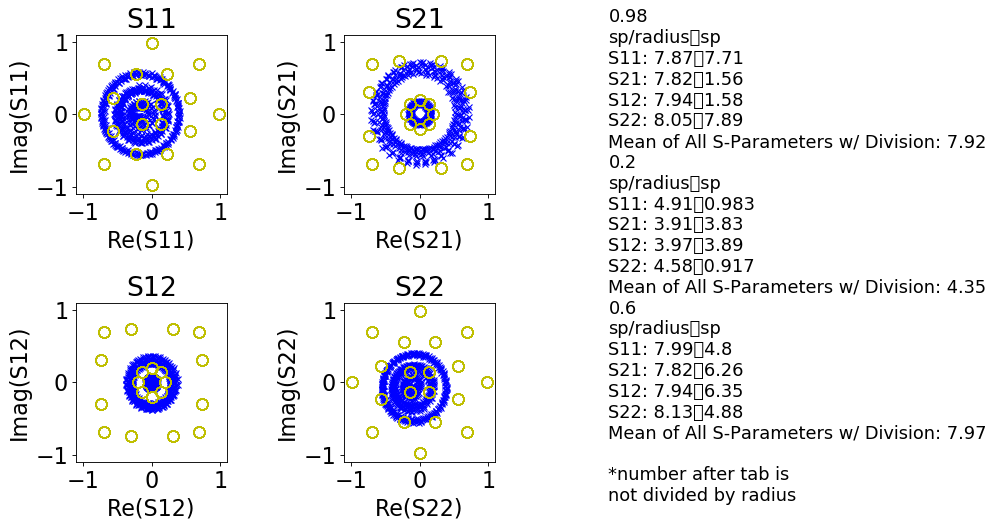

<Figure size 432x288 with 0 Axes>

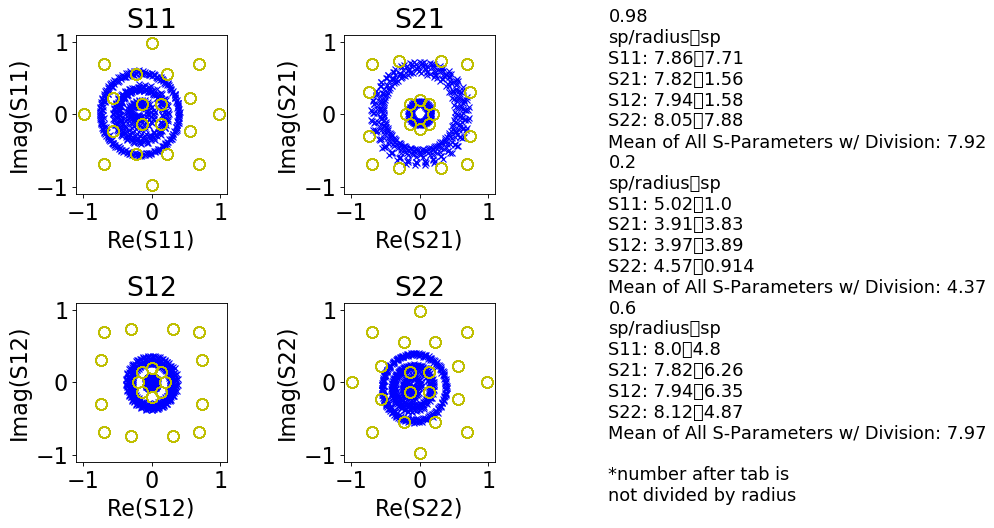

<Figure size 432x288 with 0 Axes>

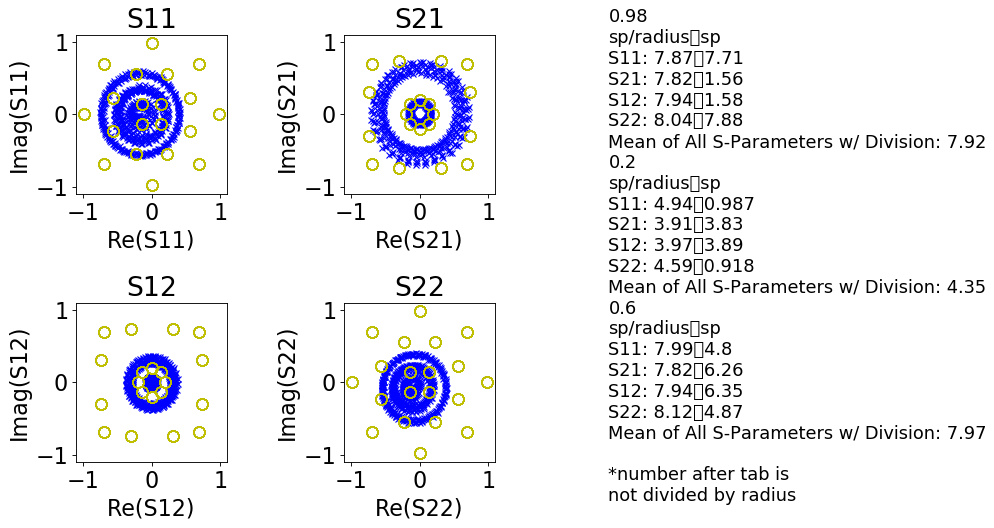

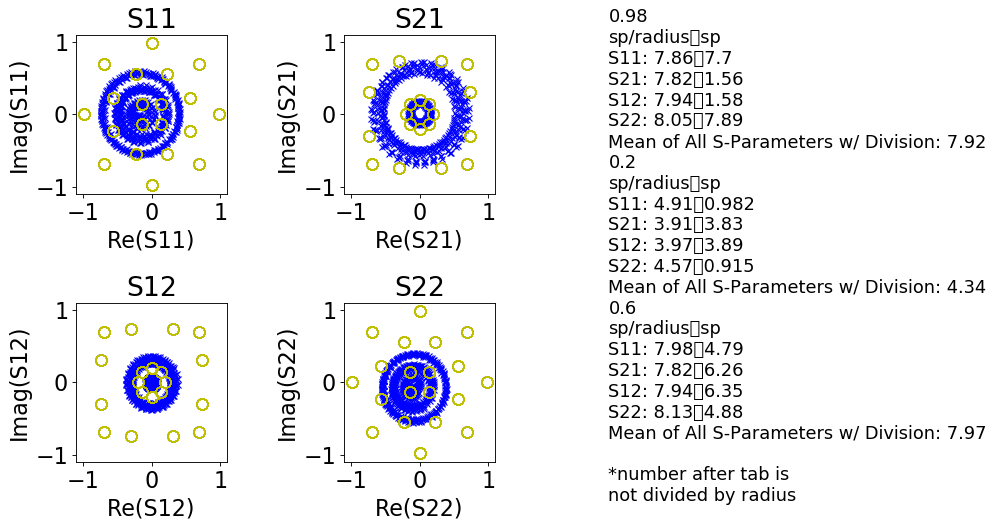

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

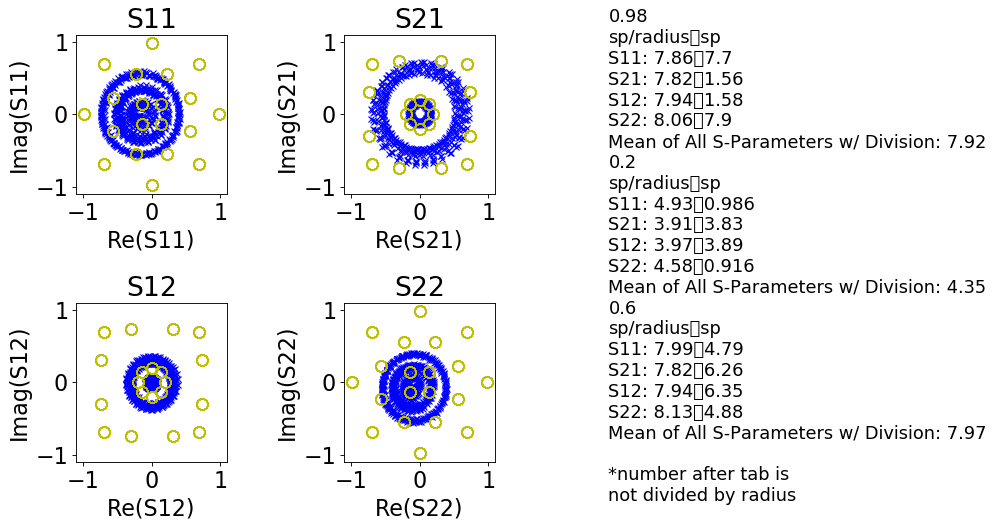

<Figure size 432x288 with 0 Axes>

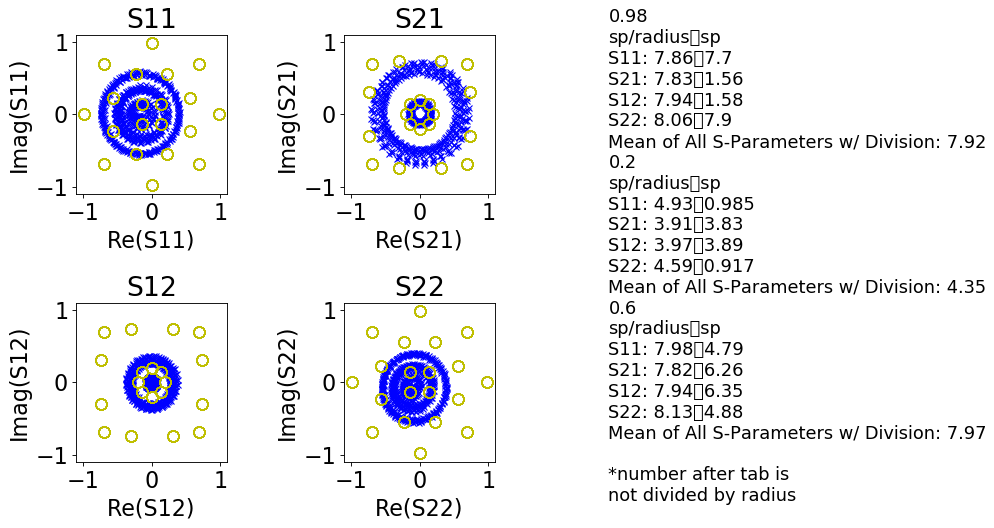

<Figure size 432x288 with 0 Axes>

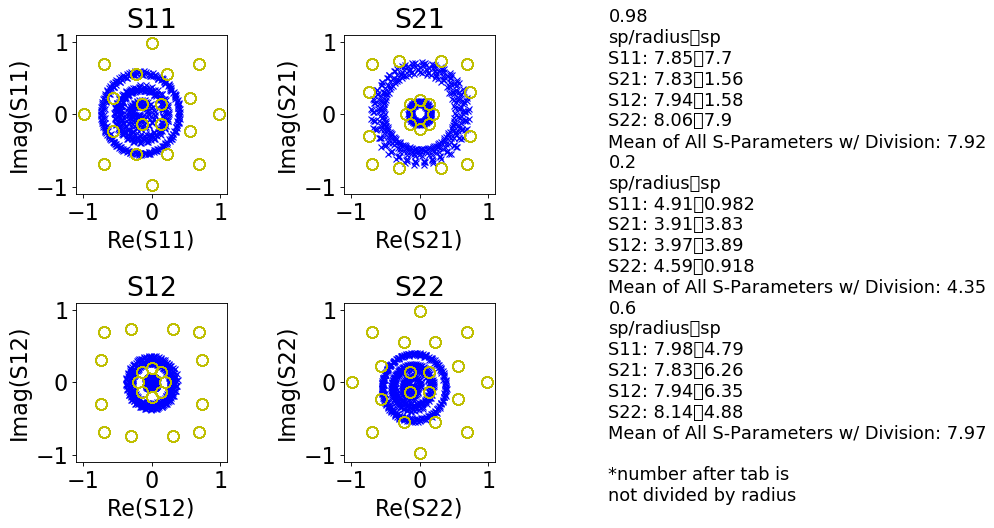

<Figure size 432x288 with 0 Axes>

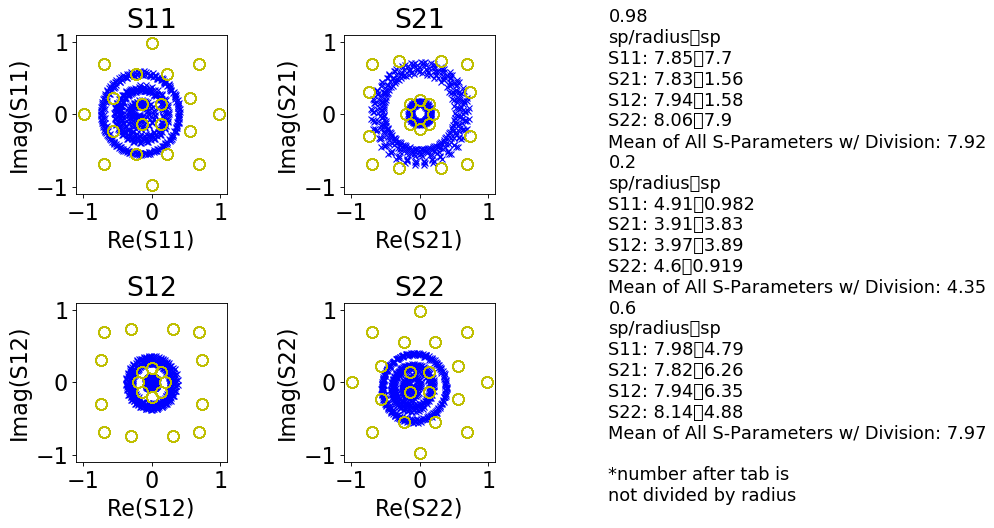

In [12]:
for i in range (0, len(cal1_2017)):
    new_correction = r"Q:\public\Aric\Summer 2018\Arpita\OSLTCalibrations_cal1\%s" % cal1_2017[i]
    new_compare = CalibrationComparison(reference_correction,new_correction)
    plt.figure(i)    
    compare_calibrations_script(reference_correction, new_correction, new_compare)

<Figure size 432x288 with 0 Axes>

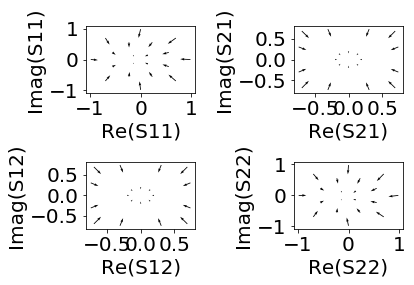

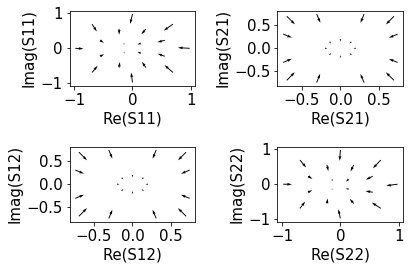

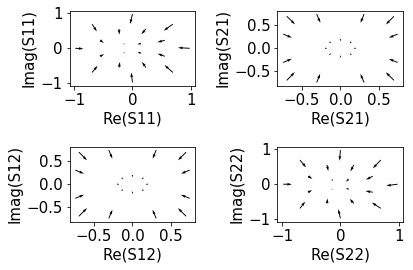

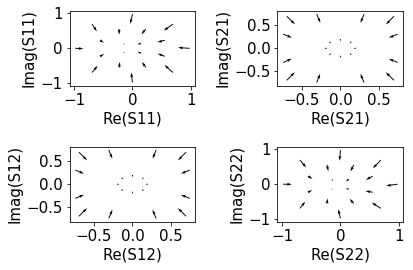

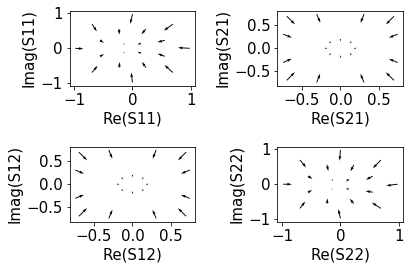

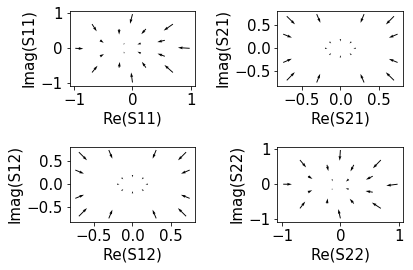

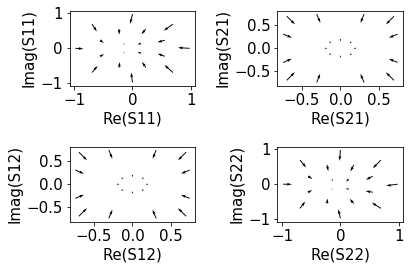

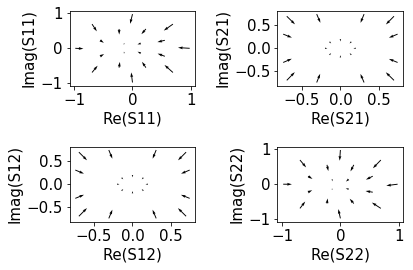

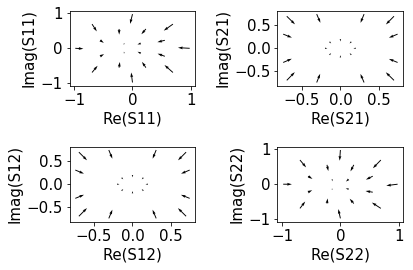

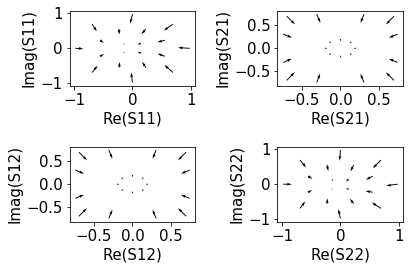

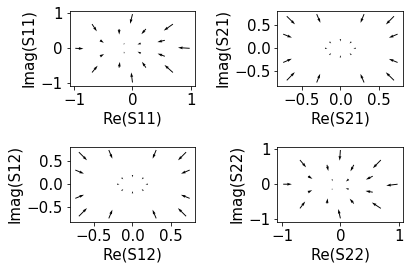

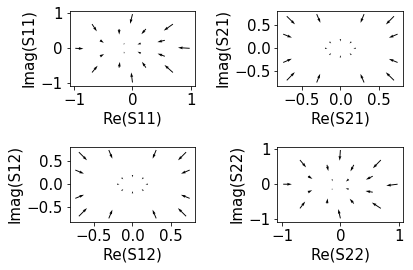

In [23]:
for i in range (0, len(cal1_2017)):
    new_correction = r"Q:\public\Aric\Summer 2018\Arpita\OSLTCalibrations_cal1\%s" % cal1_2017[i]
    new_compare = CalibrationComparison(reference_correction,new_correction)
    plt.figure(i)    
    new_compare.vector_field_complex_plot_compare(reference_correction, new_correction)

In [25]:
cal2_2017 = ["Solution20170804.s4p", "Solution20170809.s4p", "Solution20170810.s4p", "Solution20170811.s4p",
           "Solution20170814.s4p", "Solution20170824.s4p", "Solution20171006.s4p", "Solution20171011.s4p",
           "Solution20171012.s4p", "Solution20171016.s4p", "Solution20171017.s4p"]

<Figure size 432x288 with 0 Axes>

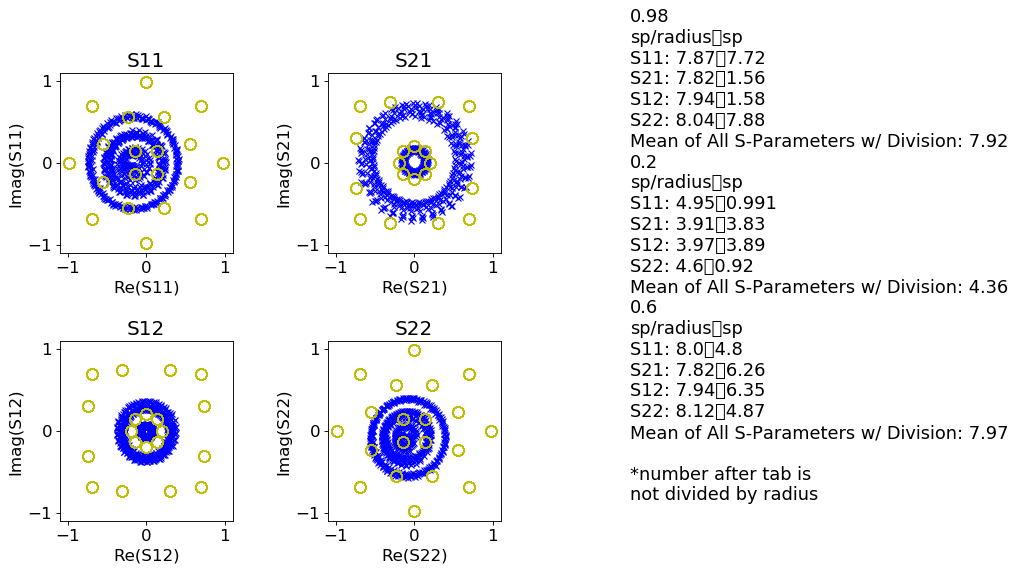

<Figure size 432x288 with 0 Axes>

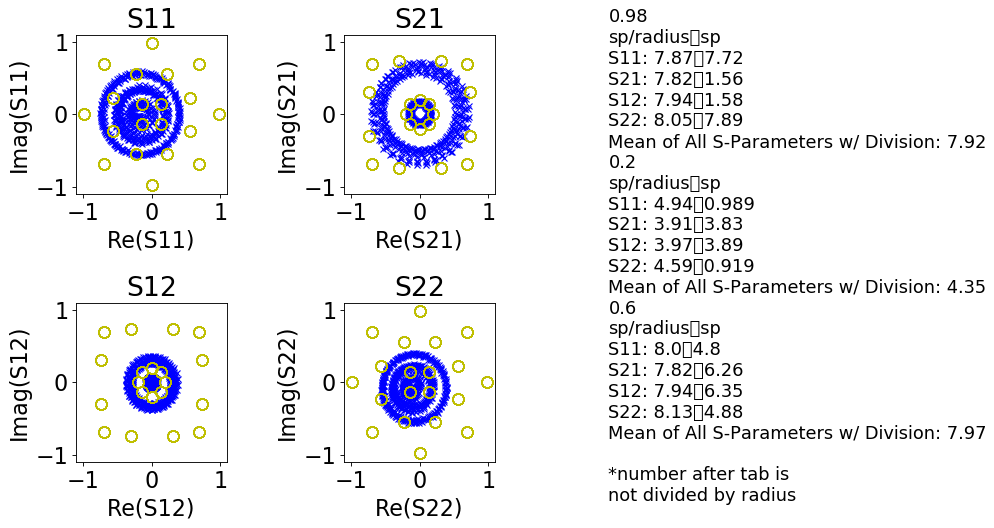

<Figure size 432x288 with 0 Axes>

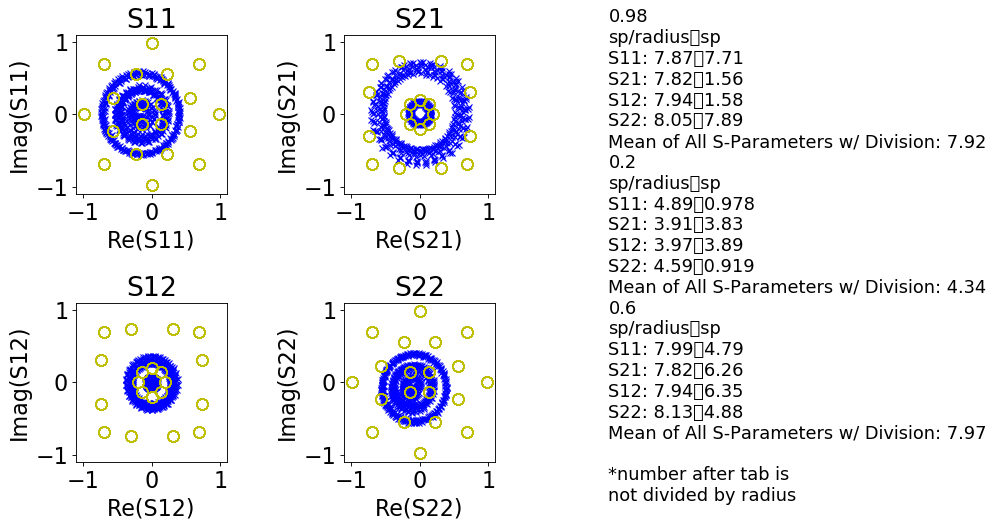

<Figure size 432x288 with 0 Axes>

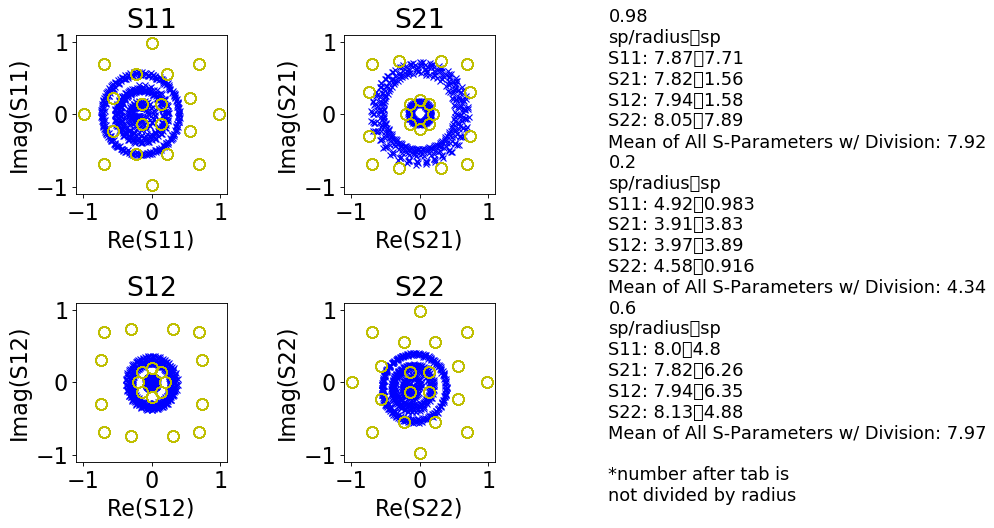

<Figure size 432x288 with 0 Axes>

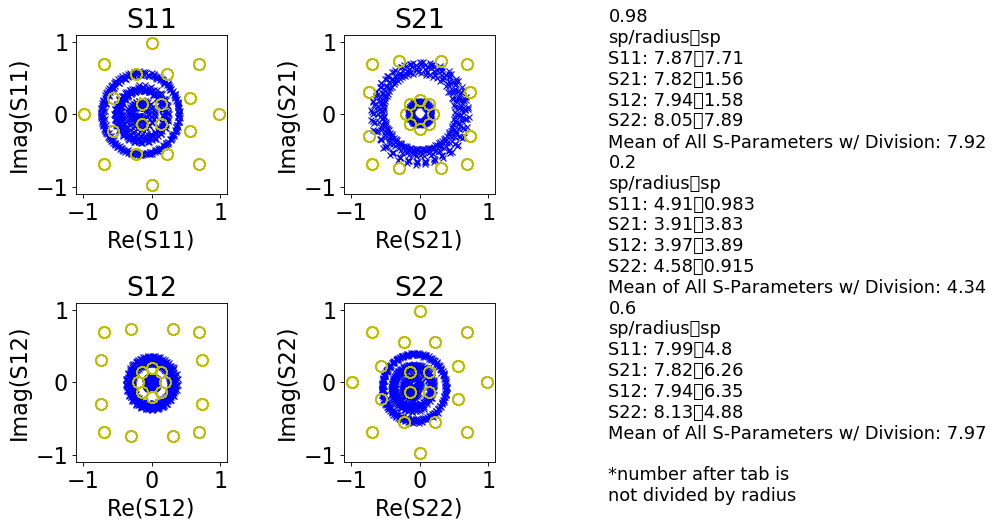

<Figure size 432x288 with 0 Axes>

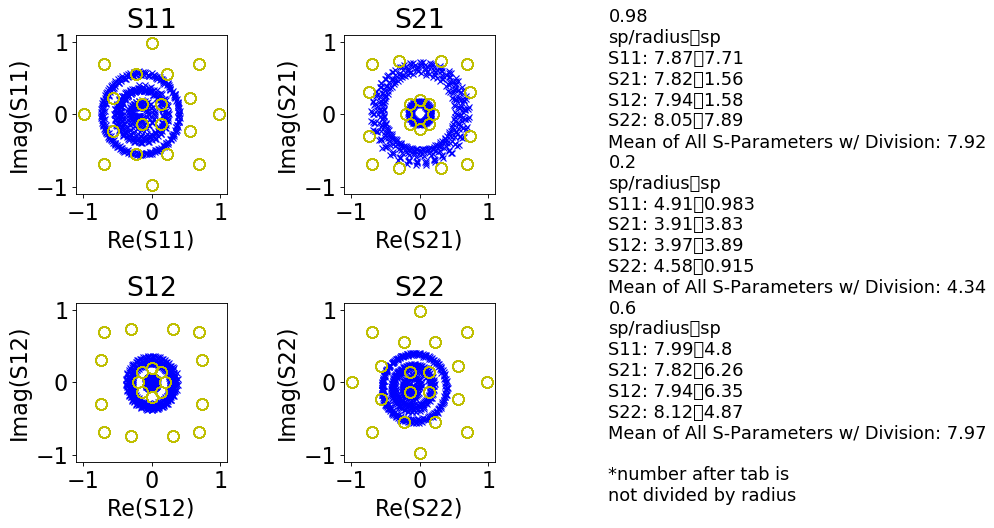

<Figure size 432x288 with 0 Axes>

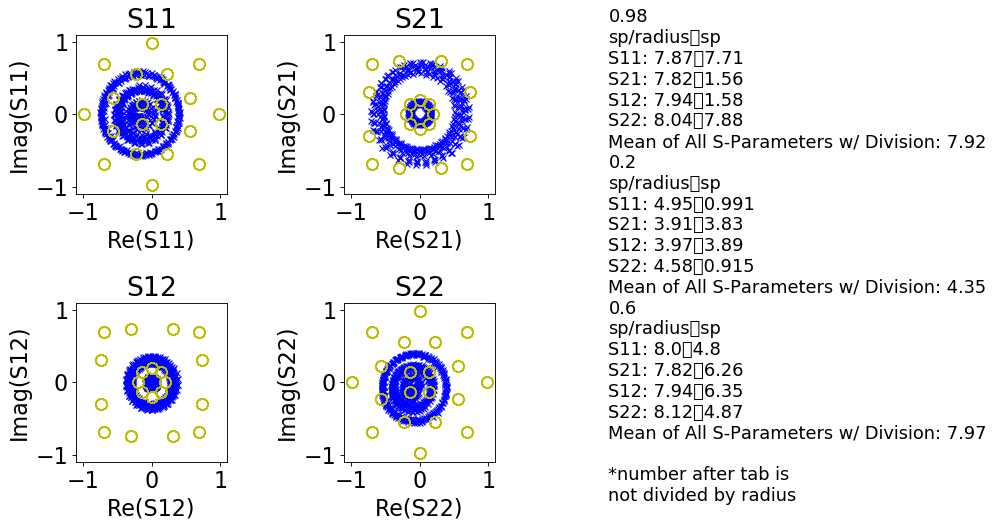

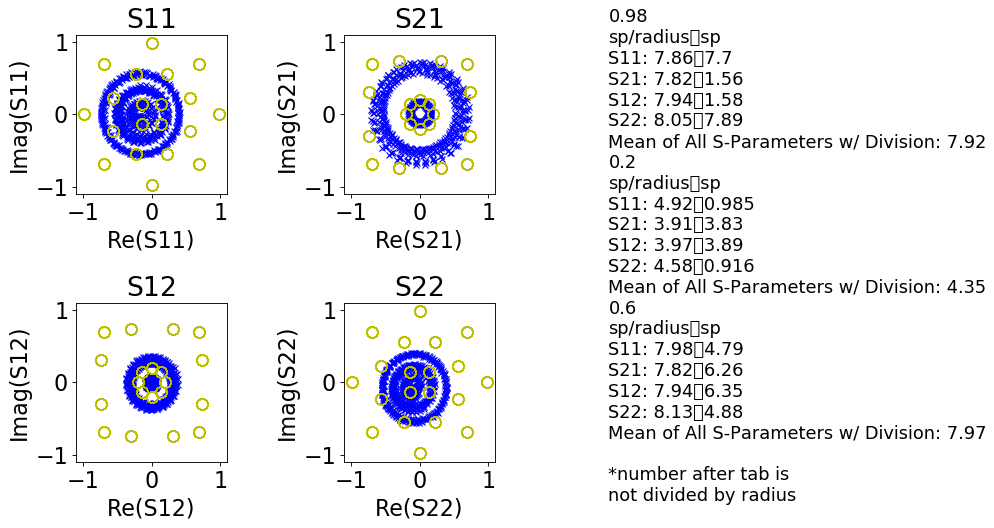

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

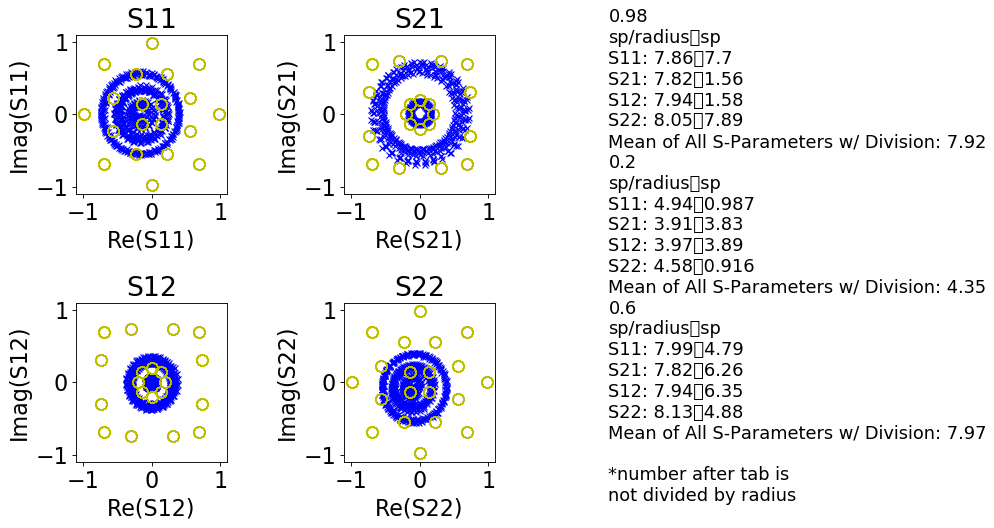

<Figure size 432x288 with 0 Axes>

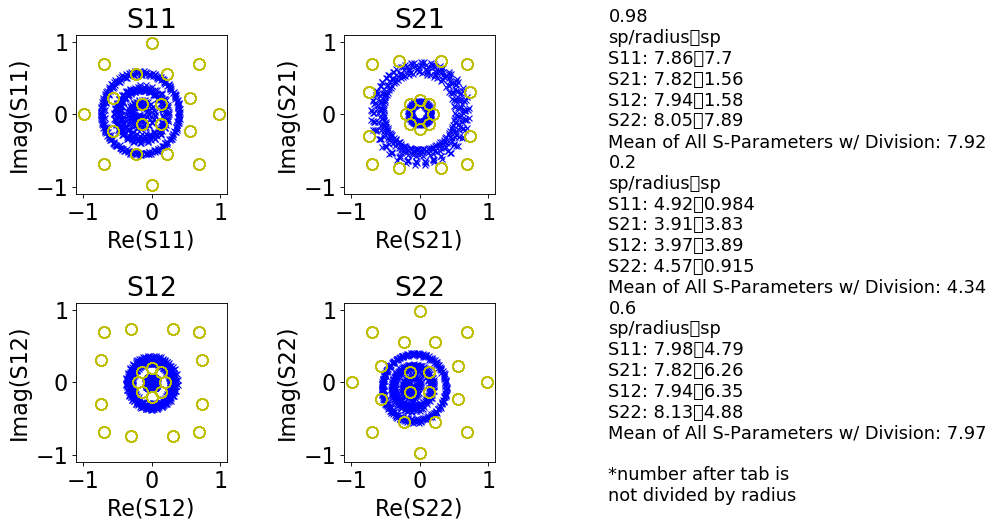

<Figure size 432x288 with 0 Axes>

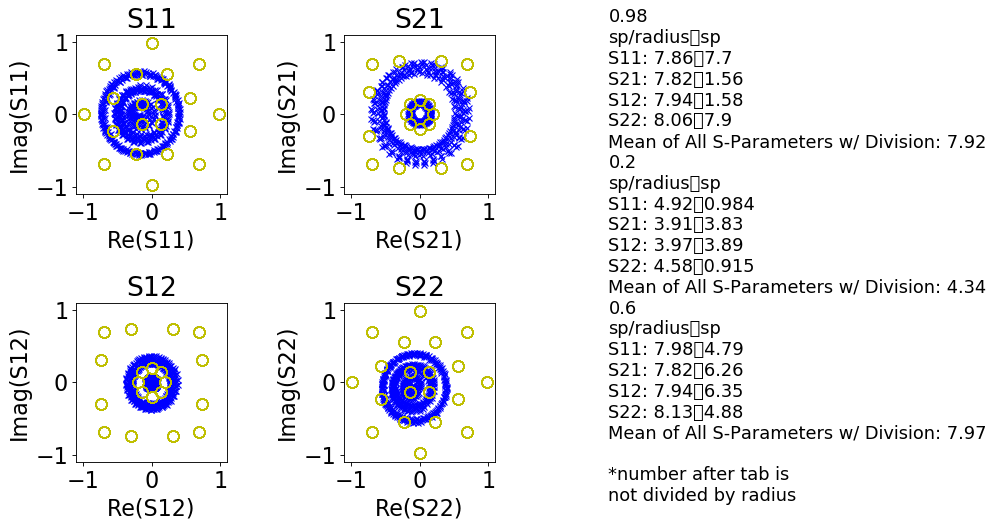

In [26]:
for i in range (0, len(cal2_2017)):
    new_correction = r"Q:\public\Aric\Summer 2018\Arpita\OSLTCalibrations _cal2\%s" % cal2_2017[i]
    new_compare = CalibrationComparison(reference_correction,new_correction)
    plt.figure(i)
    compare_calibrations_script(reference_correction, new_correction, new_compare)

In [36]:
figure(1).savefig("fig1")

NameError: name 'figure' is not defined

<Figure size 432x288 with 0 Axes>

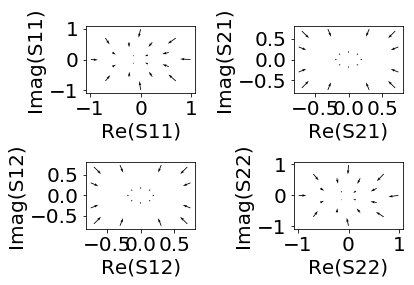

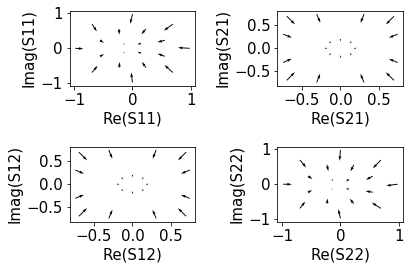

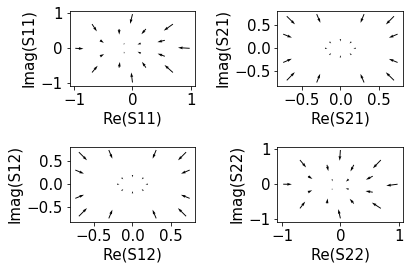

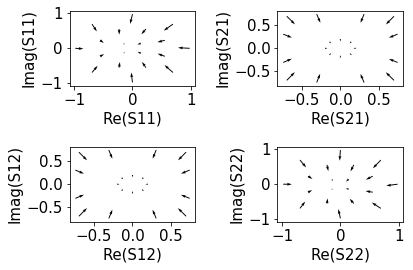

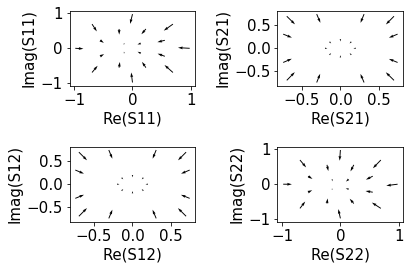

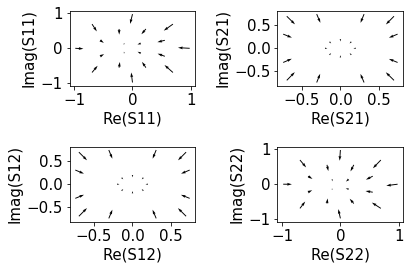

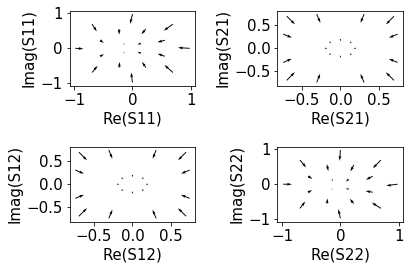

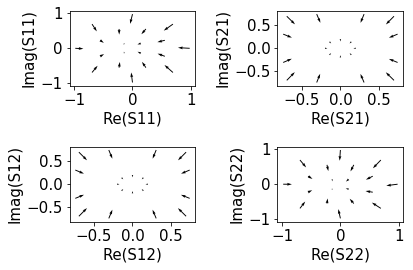

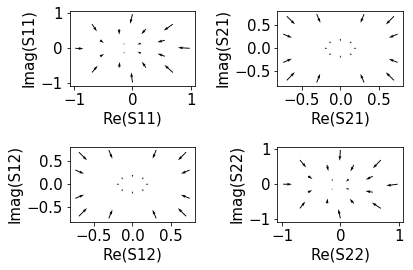

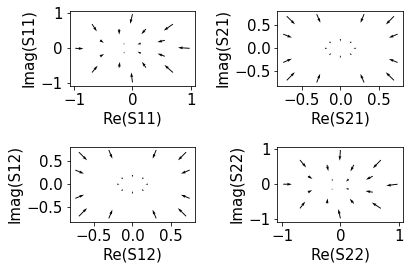

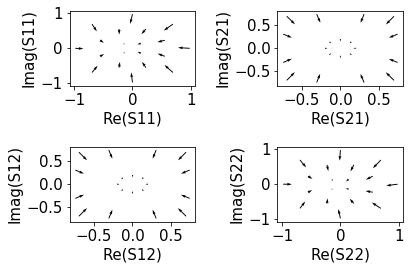

In [27]:
for i in range (0, len(cal2_2017)):
    new_correction = r"Q:\public\Aric\Summer 2018\Arpita\OSLTCalibrations _cal2\%s" % cal2_2017[i]
    new_compare = CalibrationComparison(reference_correction,new_correction)
    plt.figure(i)    
    new_compare.vector_field_complex_plot_compare(reference_correction, new_correction)

In [29]:
cal1_2016 = ["Solution20160822.s4p", "Solution20160824.s4p", "Solution20160825.s4p", "Solution20160826.s4p",
           "Solution20160914.s4p", "Solution20160915.s4p", "Solution20160916.s4p", "Solution20160919.s4p",
           "Solution20160920.s4p", "Solution20160921.s4p", "Solution20160923.s4p", "Solution20160926.s4p"]

<Figure size 432x288 with 0 Axes>

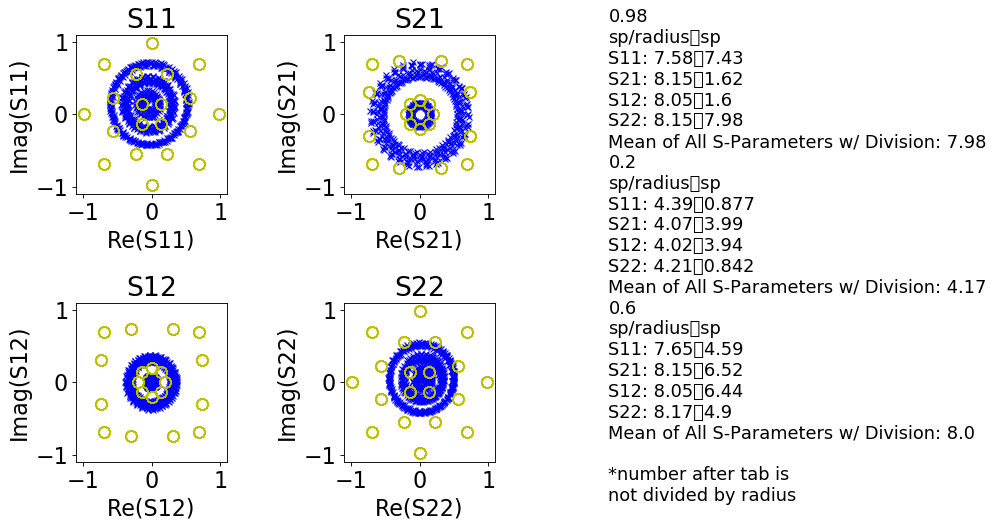

<Figure size 432x288 with 0 Axes>

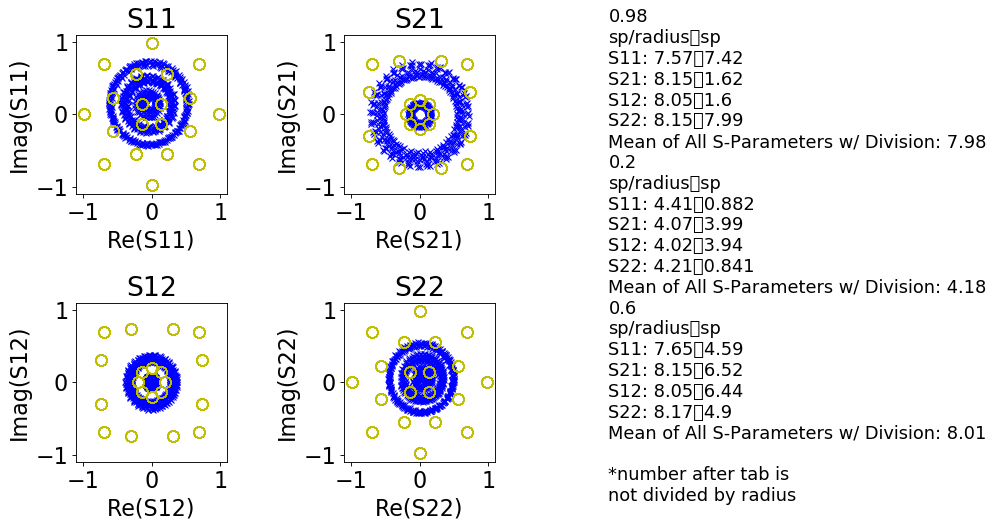

<Figure size 432x288 with 0 Axes>

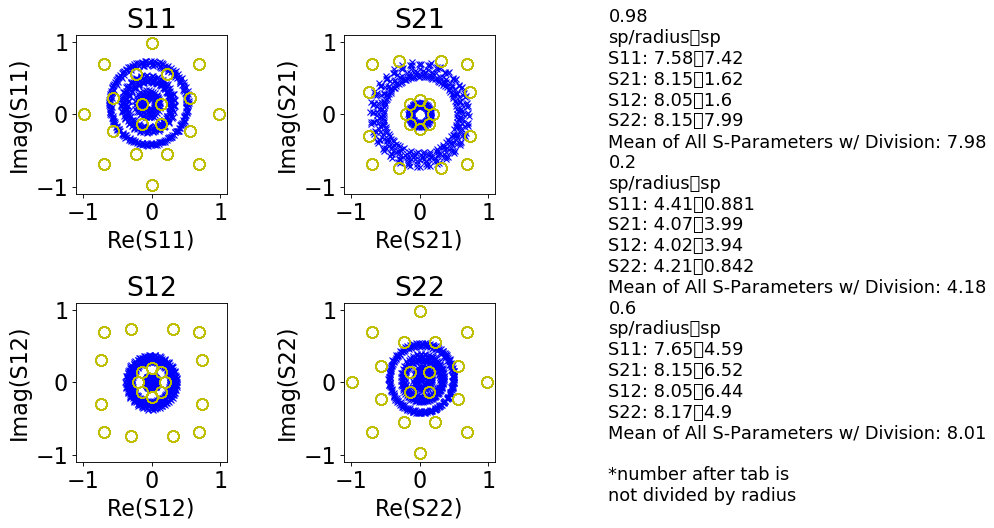

<Figure size 432x288 with 0 Axes>

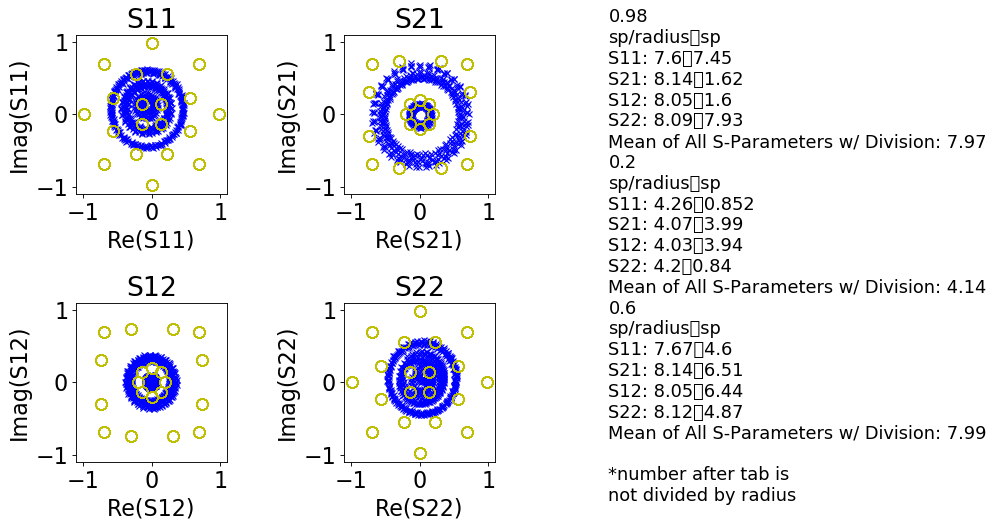

<Figure size 432x288 with 0 Axes>

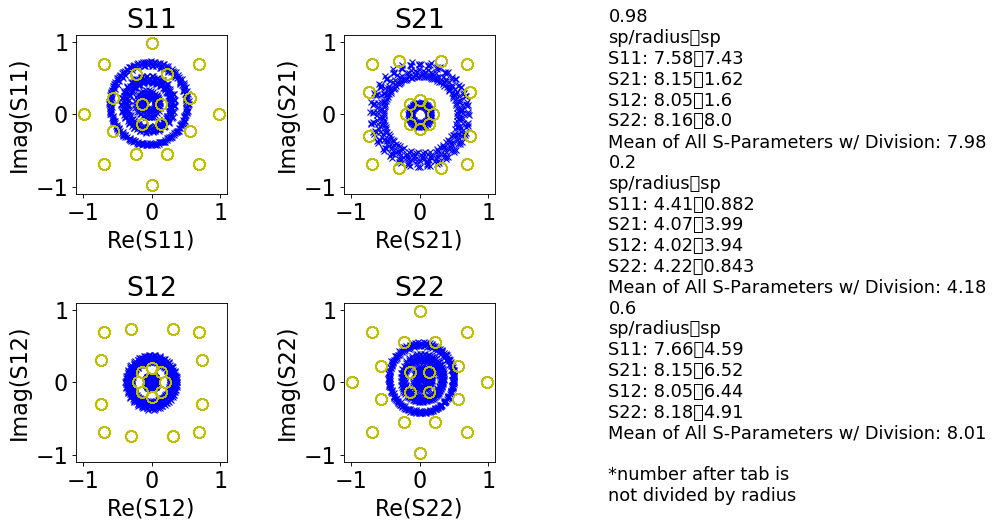

<Figure size 432x288 with 0 Axes>

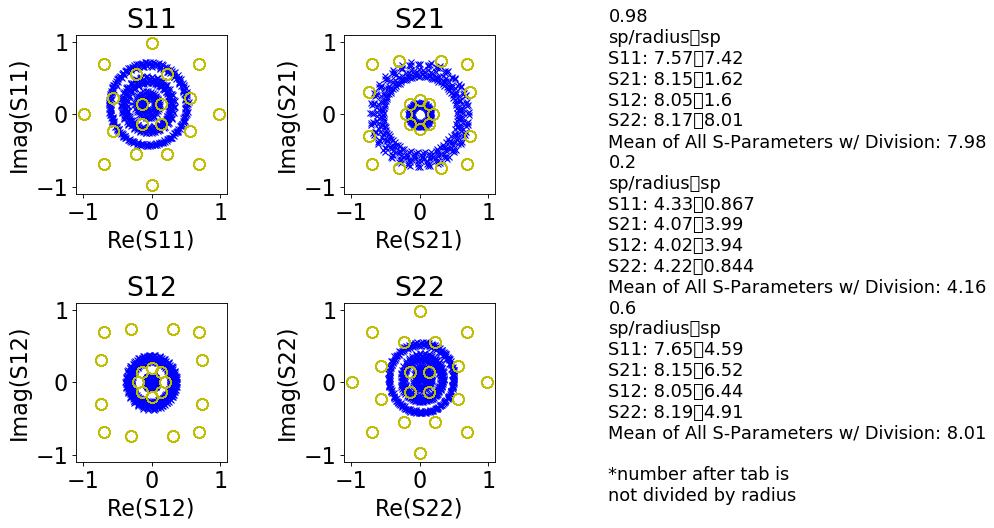

<Figure size 432x288 with 0 Axes>

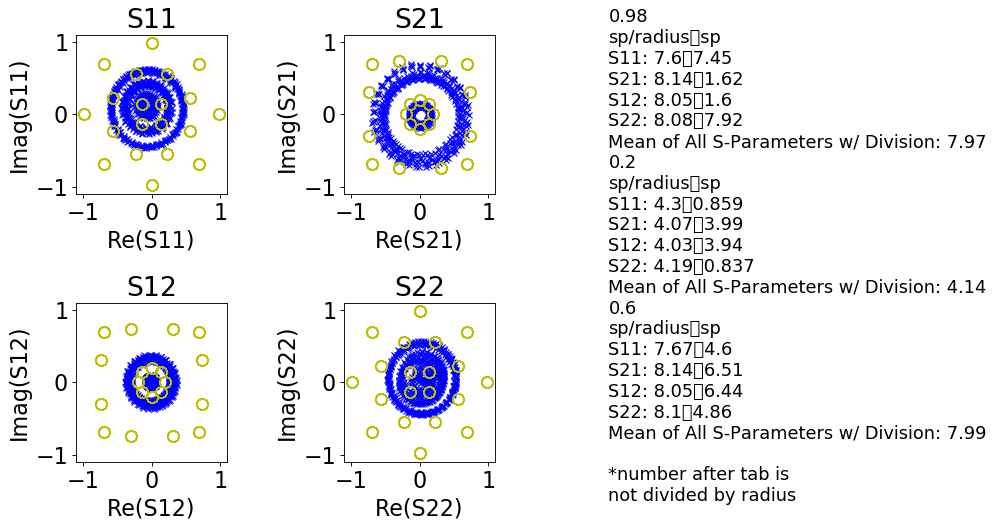

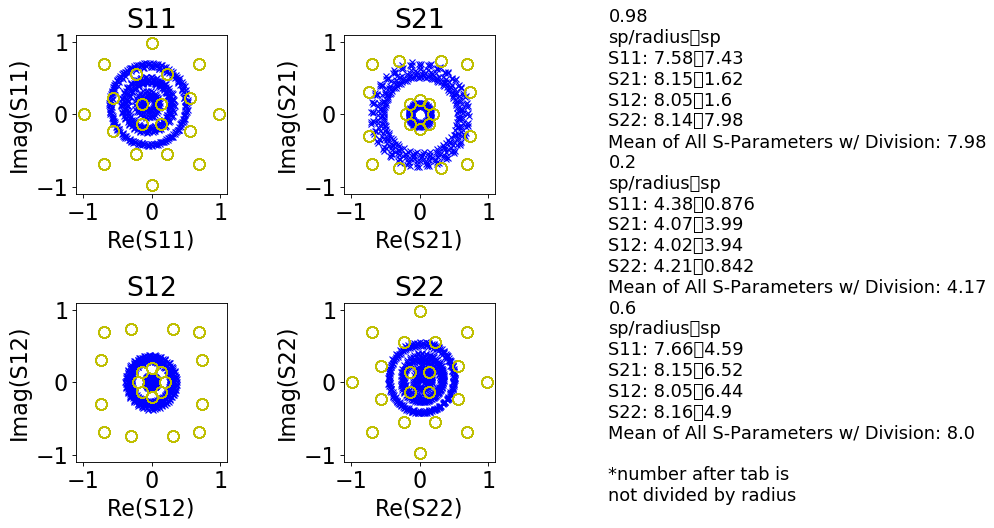

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

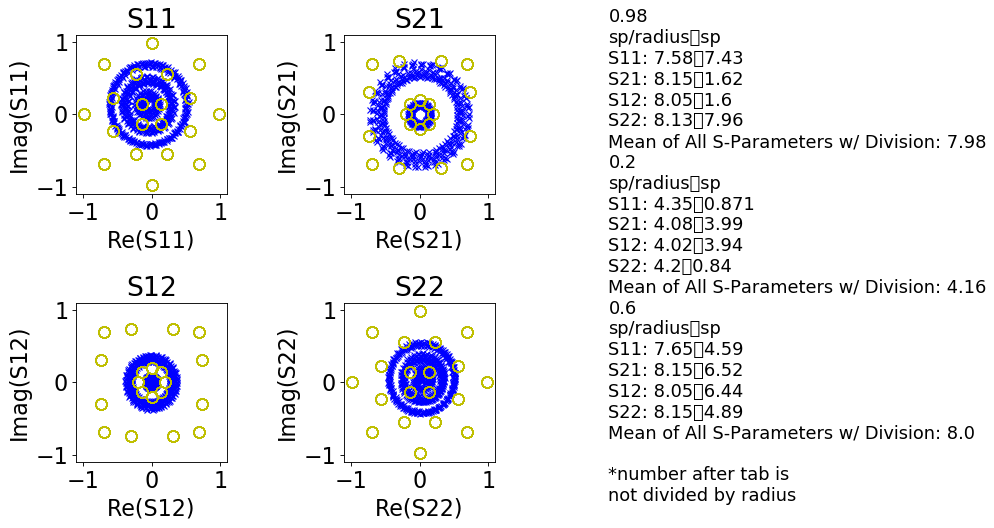

<Figure size 432x288 with 0 Axes>

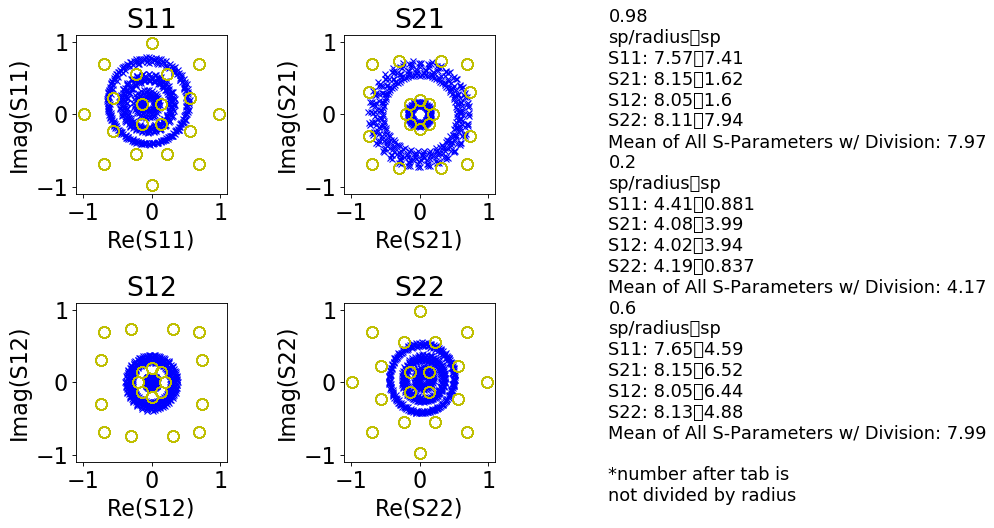

<Figure size 432x288 with 0 Axes>

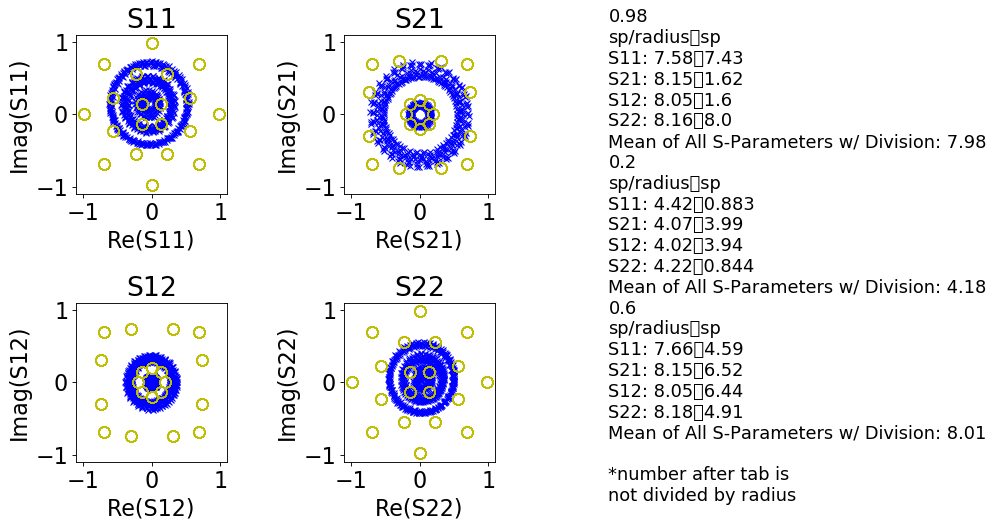

<Figure size 432x288 with 0 Axes>

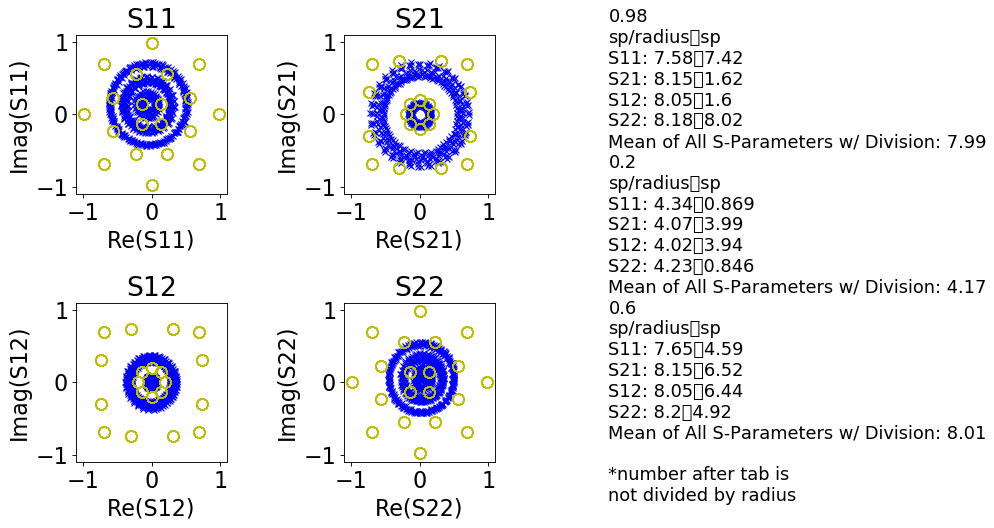

In [34]:
for i in range (0, len(cal1_2016)):
    new_correction = r"Q:\public\Aric\Summer 2018\Arpita\OSLTCalibrations2016_cal1\%s" % cal1_2016[i]
    new_compare = CalibrationComparison(reference_correction,new_correction)
    plt.figure(i)    
    compare_calibrations_script(reference_correction, new_correction, new_compare)

<Figure size 432x288 with 0 Axes>

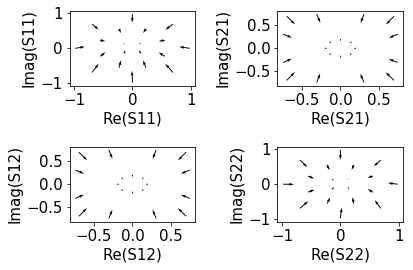

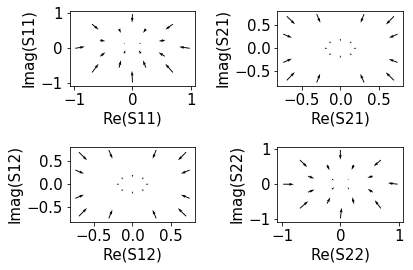

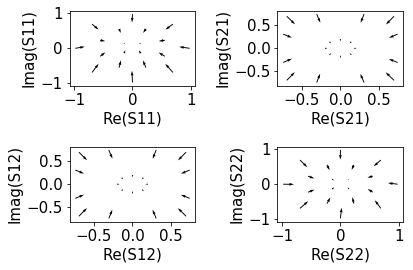

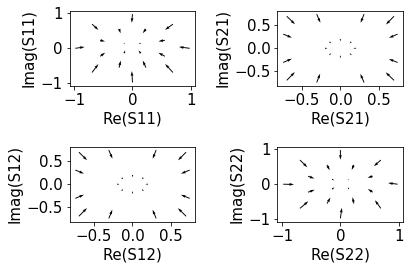

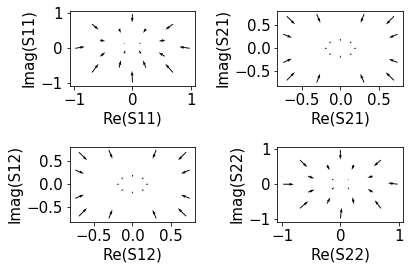

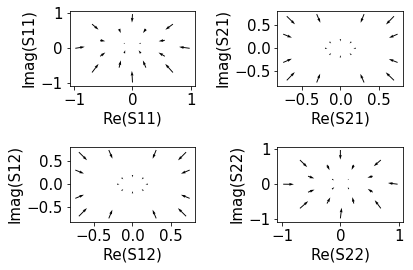

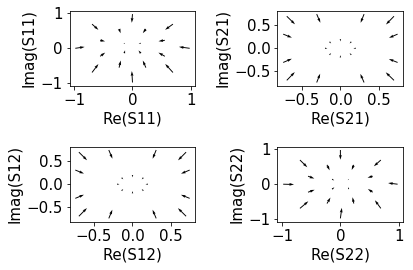

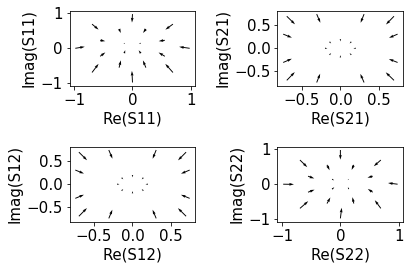

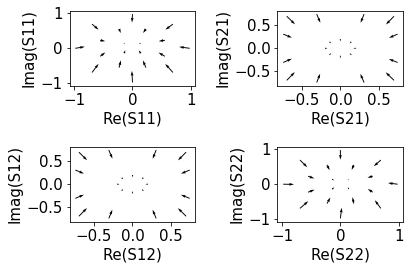

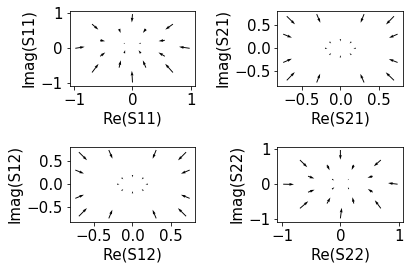

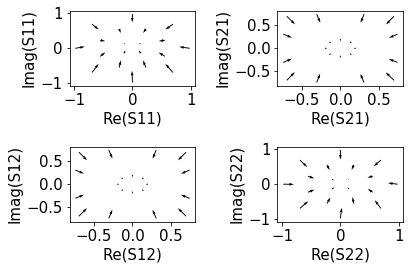

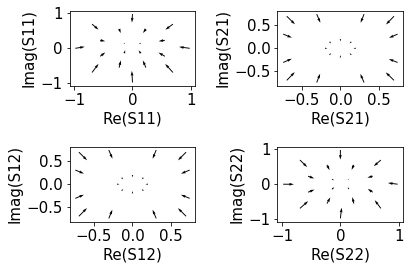

In [30]:
for i in range (0, len(cal1_2016)):
    new_correction = r"Q:\public\Aric\Summer 2018\Arpita\OSLTCalibrations2016_cal1\%s" % cal1_2016[i]
    new_compare = CalibrationComparison(reference_correction,new_correction)
    plt.figure(i)    
    new_compare.vector_field_complex_plot_compare(reference_correction, new_correction)

In [32]:
cal2_2016 = ["Solution20160822.s4p", "Solution20160824.s4p", "Solution20160825.s4p", "Solution20160826.s4p",
           "Solution20160914.s4p", "Solution20160915.s4p", "Solution20160916.s4p", "Solution20160919.s4p",
           "Solution20160920.s4p", "Solution20160921.s4p", "Solution20160923.s4p", "Solution20160926.s4p"]

<Figure size 432x288 with 0 Axes>

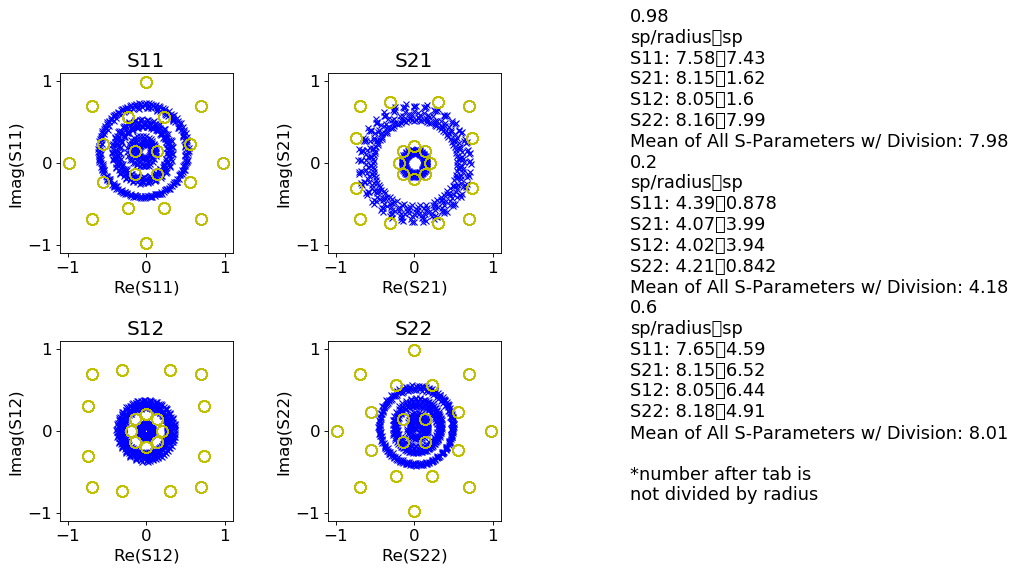

<Figure size 432x288 with 0 Axes>

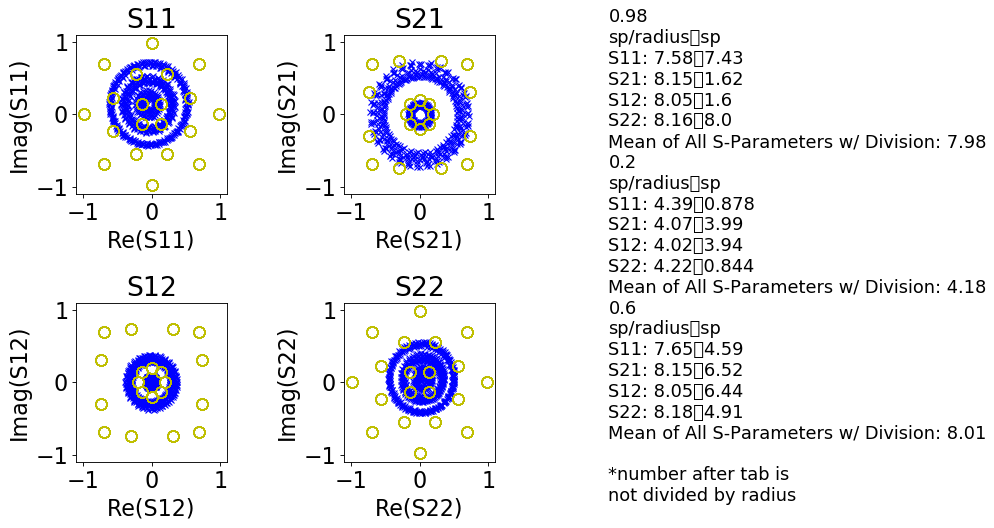

<Figure size 432x288 with 0 Axes>

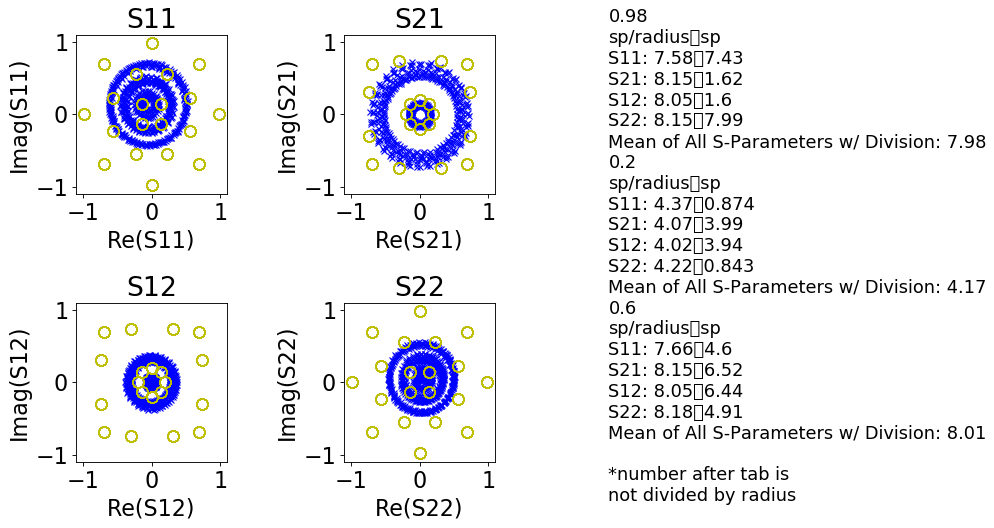

<Figure size 432x288 with 0 Axes>

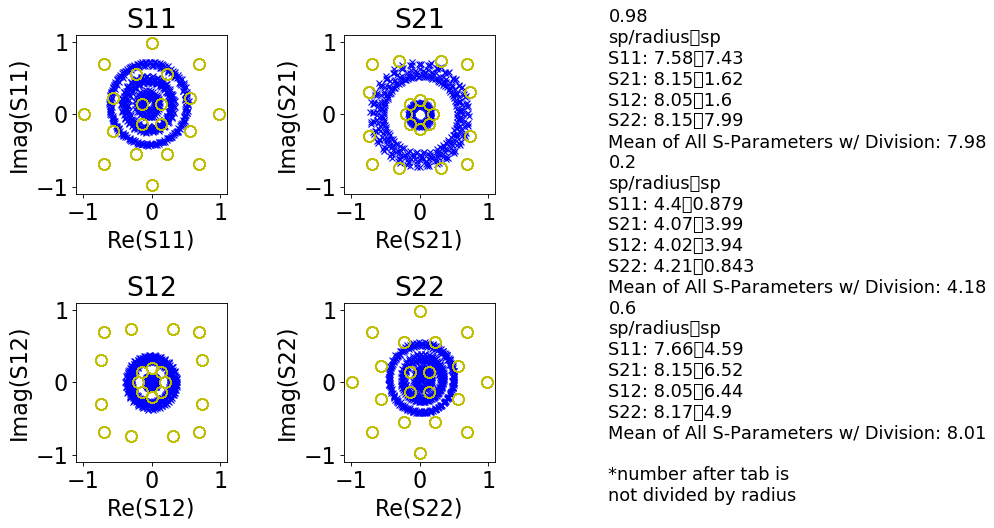

<Figure size 432x288 with 0 Axes>

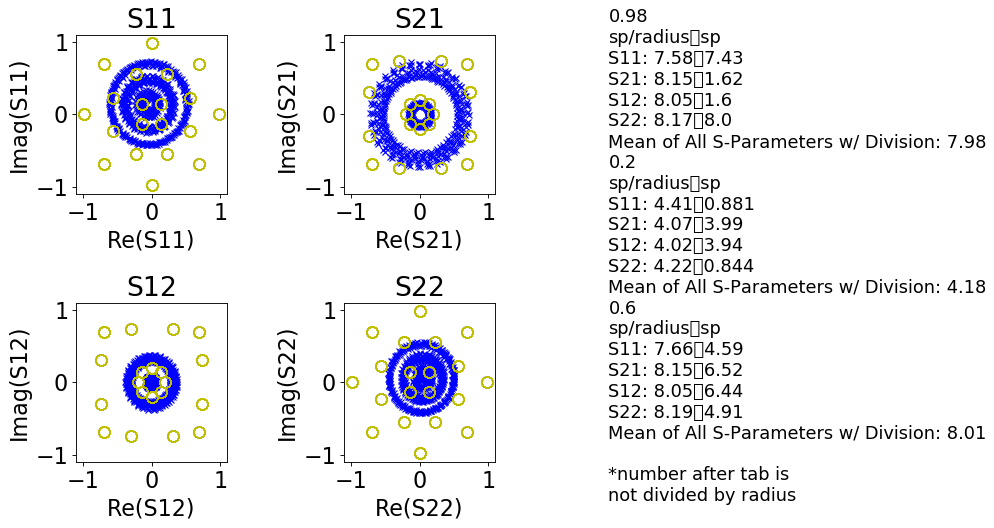

<Figure size 432x288 with 0 Axes>

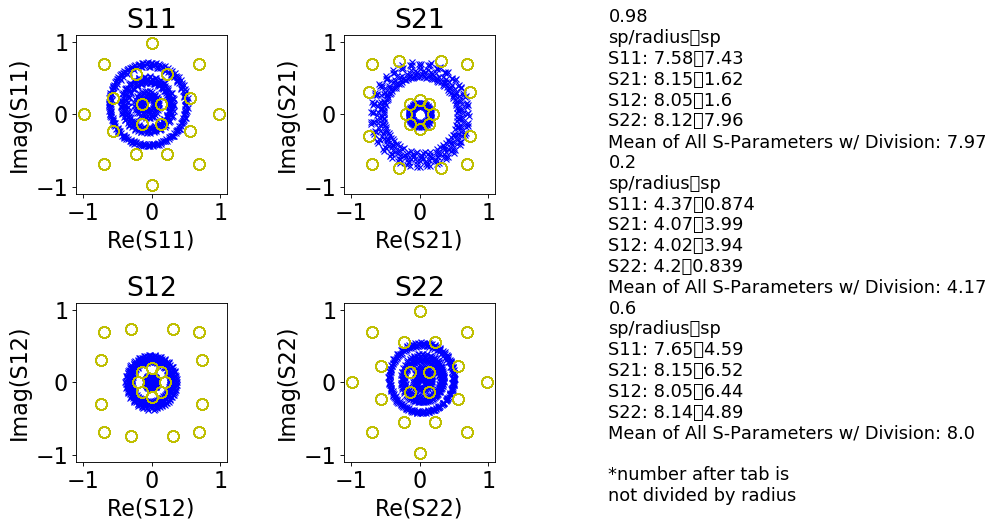

<Figure size 432x288 with 0 Axes>

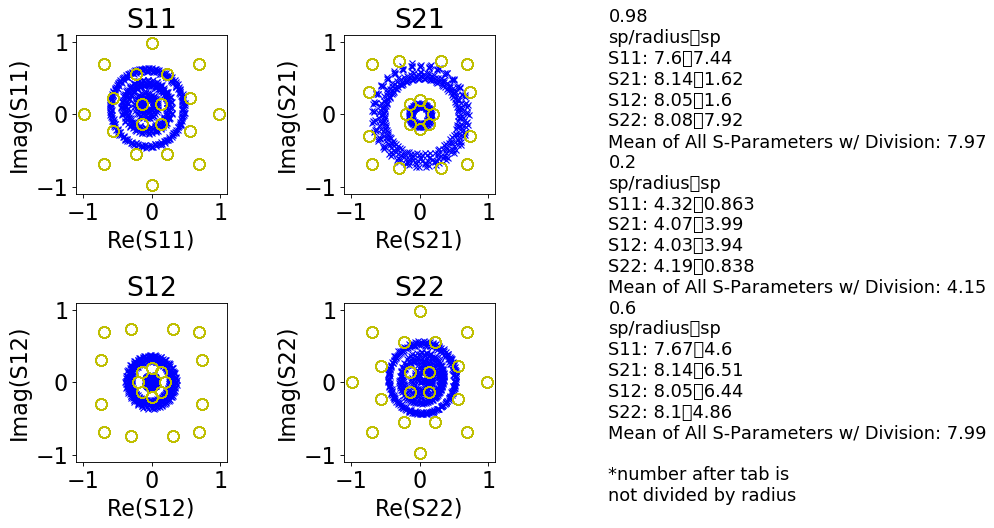

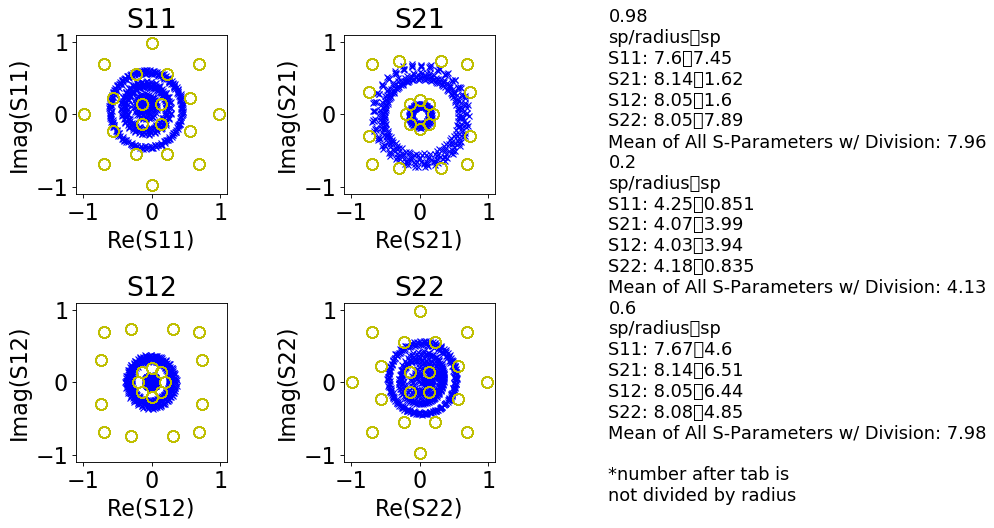

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

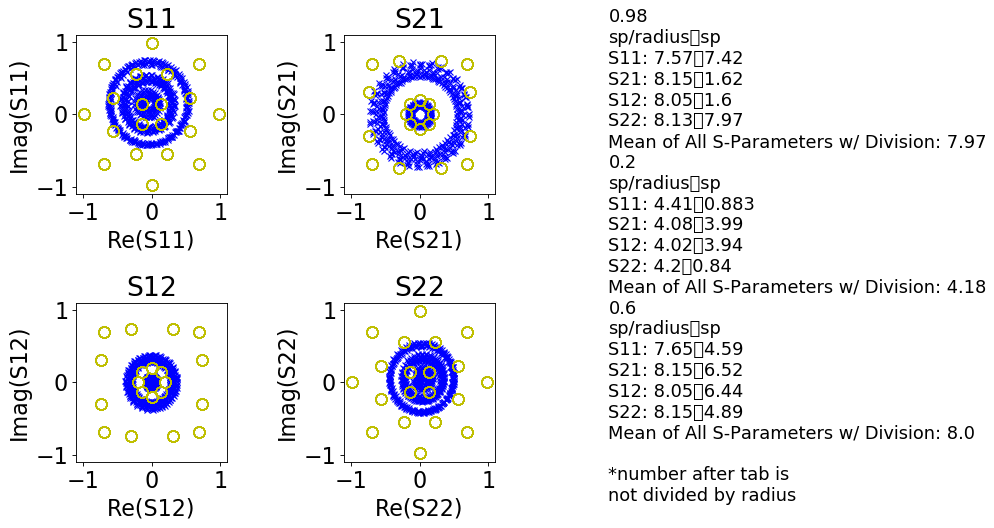

<Figure size 432x288 with 0 Axes>

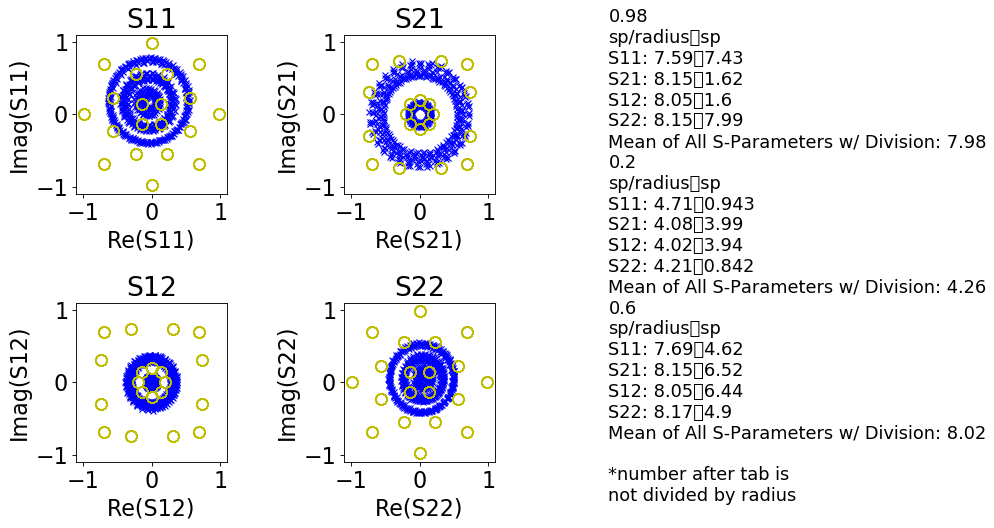

<Figure size 432x288 with 0 Axes>

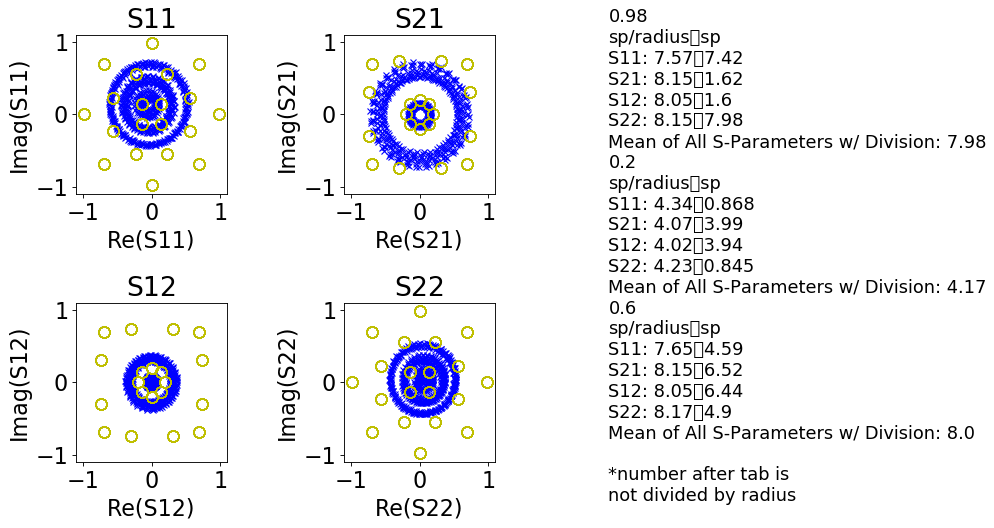

<Figure size 432x288 with 0 Axes>

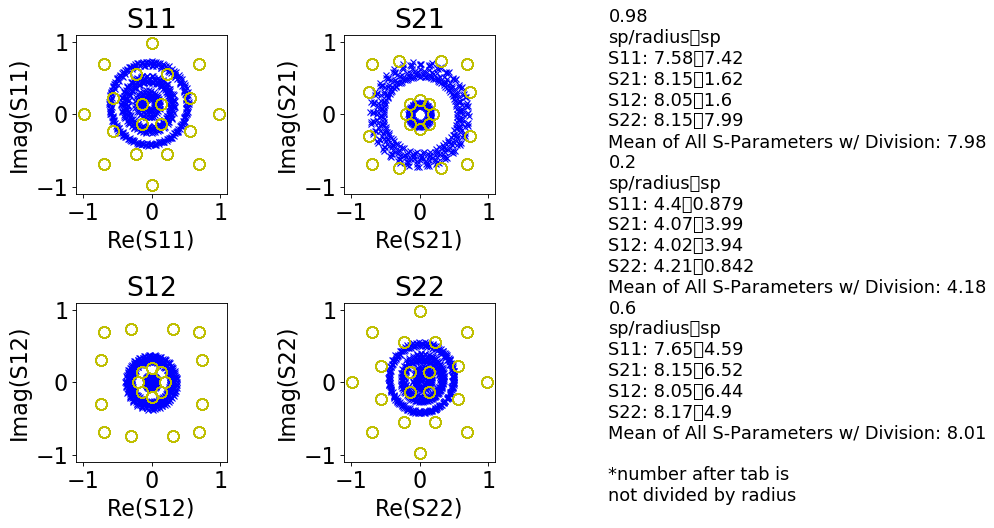

In [33]:
for i in range (0, len(cal2_2016)):
    new_correction = r"Q:\public\Aric\Summer 2018\Arpita\OSLTCalibrations2016_cal2\%s" % cal2_2016[i]
    new_compare = CalibrationComparison(reference_correction,new_correction)
    plt.figure(i)    
    compare_calibrations_script(reference_correction, new_correction, new_compare)

<Figure size 432x288 with 0 Axes>

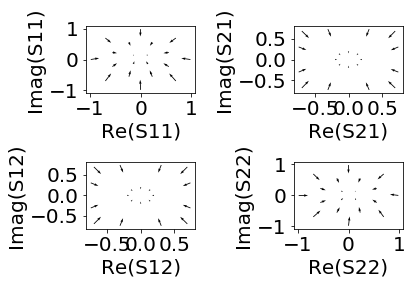

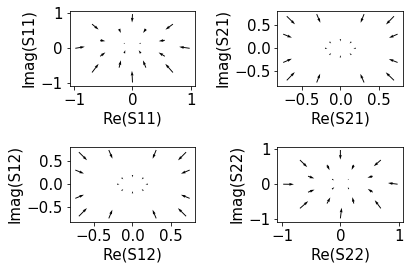

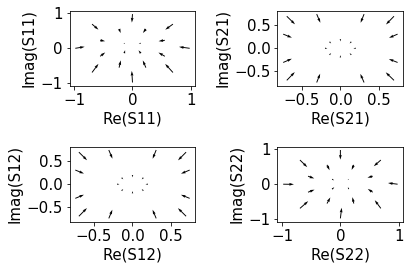

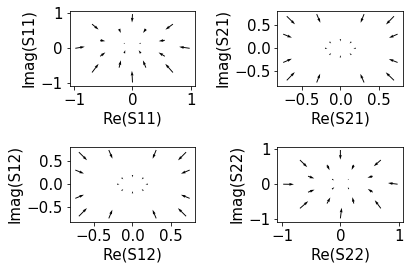

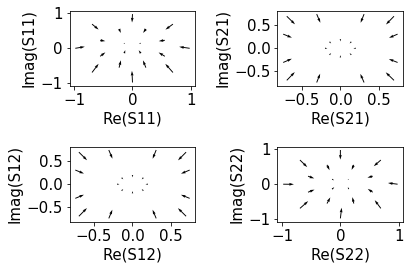

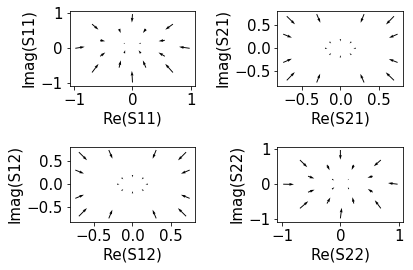

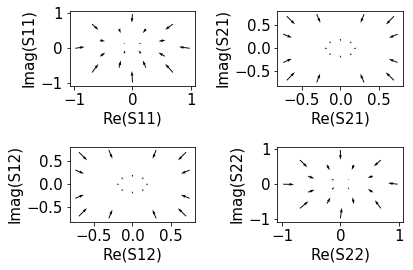

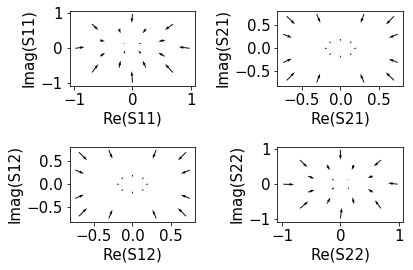

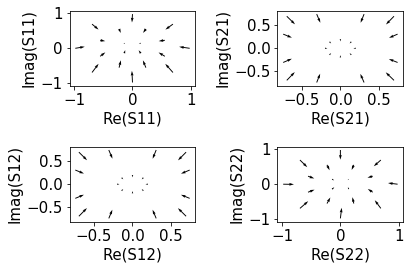

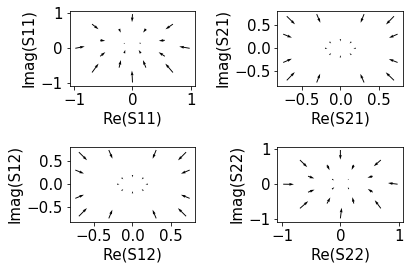

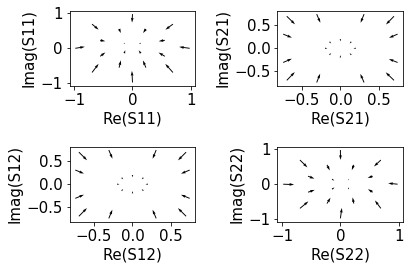

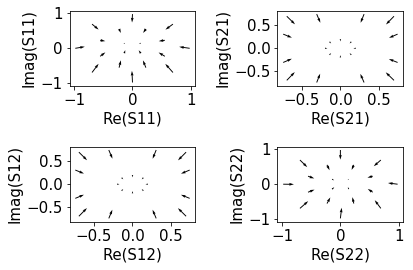

In [35]:
for i in range (0, len(cal2_2016)):
    new_correction = r"Q:\public\Aric\Summer 2018\Arpita\OSLTCalibrations2016_cal2\%s" % cal2_2016[i]
    new_compare = CalibrationComparison(reference_correction,new_correction)
    plt.figure(i)    
    new_compare.vector_field_complex_plot_compare(reference_correction, new_correction)

In [69]:
print standard_compare1.get_magnitude_of_mean_difference_vector_for_radius(0.2)

0.2
sp/radius	sp
S11: 3.55	0.71
S21: 3.53	3.46
S12: 3.58	3.51
S22: 3.55	0.711
Mean of All S-Parameters w/ Division: 3.55


In [63]:
compare_calibrations_script(reference_correction_new_standard, comparison_correction_standard3, standard_compare1)

In [28]:
# standard_compare1.comparison_s2ps_dut_plane[0].show()

In [15]:
# new_compare.s2p_list[0].options["column_types"]=["float" for i in range(len(new_compare.s2p_list[0].column_names))]
# new_compare.comparison_s2ps_dut_plane[0].options["column_types"]=["float" for i in range(len(new_compare.s2p_list[0].column_names))]
# difference=frequency_model_difference(new_compare.s2p_list[0],new_compare.comparison_s2ps_dut_plane[0])

In [16]:
# plt.plot(difference["Frequency"],difference["reS11"])
# plt.xlabel("Frequency (GHz)")
# plt.ylabel("re(S11 Difference)")
# plt.show()

In [70]:
%matplotlib wx
plt.plot(['TRL', 'SOLT', 'MTRL', 'LRL'], [0,0.0564, 0.00483, 3.55],'o')
plt.xlabel("Standard")
plt.ylabel("Mean Calibration Difference")
plt.grid(True)
plt.show()

In [ ]:
compare_list=[]
for j in range(len(new_compare.s2p_list)):
    new_compare.s2p_list[j].options["column_types"]=["float" for i in range(len(new_compare.s2p_list[j].column_names))]
    new_compare.comparison_s2ps_dut_plane[j].options["column_types"]=["float" for i in range(len(new_compare.s2p_list[j].column_names))]
    difference=frequency_model_difference(new_compare.s2p_list[j],new_compare.comparison_s2ps_dut_plane[j])
    compare_list.append(difference)

In [ ]:
for difference in compare_list:
    plt.plot(difference["Frequency"],difference["reS21"])
plt.xlabel("Frequency (GHz)")
plt.ylabel("re(S21 Difference)")
plt.show()

In [ ]:
s4p = SNP(r"C:\Users\anb33\Desktop\Compare Stuff\Solution_8.s4p")
s4p.show()